In [1]:
import sys
# sys.path.append("/home/federico/programming/CM/")
sys.path.append("/home/federico/Desktop/University/CM/")


from Network import NR, NC
import src.utils as utils
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, train_test_split
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 17})
plt.rcParams.update({'figure.figsize': (8, 6)})

In [2]:
def plot_stats(conf, dataset, test, net, save=False, log=True):
    print(conf)
    net.plot_results(f"{dataset}_{test}_loss", score=False, save=save, log=log)
    net.plot_results(f"{dataset}_{test}_loss", score=False, save=save, time=True, log=log)
    net.plot_results(f"{dataset}_{test}_score", score=True, save=save, log=log)
    net.plot_results(f"{dataset}_{test}_score", score=True, save=save, time=True, log=log)

    net.plot_grad(f"{dataset}_{test}", save=save)
    print(net.best_score())

In [3]:
def report_plots(params, dataset, net_SGD, net_SGD_nest, net_Adam, score=False):
        
    sgd_loss = net_SGD.train_loss
    sgd_nest_loss = net_SGD_nest.train_loss
    adam_loss = net_Adam.train_loss

    # Conditional configuration
    x_label_time = 'Execution Time'
    x_label_ep = 'Epochs'
    curve_type = 'Loss' if not score else 'Score'

    train_res_SGD = net_SGD.train_scores if score else net_SGD.train_loss
    train_res_SGD_nest = net_SGD_nest.train_scores if score else net_SGD_nest.train_loss
    train_res_Adam = net_Adam.train_scores if score else net_Adam.train_loss
    x_SGD_time = net_SGD.epochs_time
    x_SGD_ep = list(range(len(train_res_SGD)))
    x_SGD_nest_time = net_SGD_nest.epochs_time
    x_SGD_nest_ep = list(range(len(train_res_SGD_nest)))
    x_Adam_time = net_Adam.epochs_time
    x_Adam_ep = list(range(len(train_res_Adam)))
    
    
    print("----- SGD -----")
    print(params[dataset]['SGD'])
    print(net_SGD.best_score(),"\n")
    
    print("----- SGD nesterov-----")
    print(params[dataset]['SGD'])
    print(net_SGD_nest.best_score(),"\n")

    print("----- Adam -----")
    print(params[dataset]['Adam'])
    print(net_Adam.best_score(),"\n")

    def plot_internal(x_datas, y_datas, x_label, y_label, title, loc='best'):
        plt.semilogy(x_datas[0], y_datas[0], '--', linewidth=2., label='SGD CM')
        plt.semilogy(x_datas[1], y_datas[1], '--', linewidth=2., label='SGD NAG')
        plt.semilogy(x_datas[2], y_datas[2], '--', linewidth=2., label='Adam')
        plt.xlabel(x_label)
        plt.ylabel (y_label)
        plt.legend(loc=loc, fontsize=13)
        plt.title (title)
        plt.show()
        plt.clf()

    plot_internal([x_SGD_time, x_SGD_nest_time, x_Adam_time], 
                  [train_res_SGD, train_res_SGD_nest, train_res_Adam],
                  x_label_time, 
                  curve_type, 
                  f'{curve_type} {dataset} dataset'
                 )
    
    plot_internal([x_SGD_ep, x_SGD_nest_ep, x_Adam_ep], 
                  [train_res_SGD, train_res_SGD_nest, train_res_Adam],
                  x_label_ep, 
                  curve_type, 
                  f'{curve_type} {dataset} dataset'
                 )
    
    plot_internal([x_SGD_ep, x_SGD_nest_ep, x_Adam_ep], 
                  [net_SGD.grad_est_per_epoch, net_SGD_nest.grad_est_per_epoch, net_Adam.grad_est_per_epoch],
                  x_label_ep, 
                  'Gradient norm', 
                  f'Gradient norms over {dataset}',
                  1
                 )

In [4]:
def report_stats(params, dataset, score=False, debug=False):
    if dataset == 'cup':
        nn = NR
        X_train, X_test, y_train, y_test = utils.load_CUP(datasets[dataset])
    else:
        X_train, X_test, y_train, y_test = utils.load_monk(datasets[dataset])
        nn = NC

    # Plots together results from SGD and Adam
    param_SGD = params[dataset]['SGD'].copy()
    param_SGD_nest = params[dataset]['SGD'].copy()
    param_Adam = params[dataset]['Adam'].copy()
    
    param_SGD['debug'] = debug
    net_SGD = nn(**param_SGD)

    param_SGD_nest['debug'] = debug
    param_SGD_nest['nesterov'] = True
    net_SGD_nest = nn(**param_SGD_nest)

    param_Adam['debug'] = debug
    net_Adam = nn(**param_Adam)    

    net_SGD.fit(X_train, y_train, test_data=(X_test, y_test))
    net_SGD_nest.fit(X_train, y_train, test_data=(X_test, y_test))
    net_Adam.fit(X_train, y_train, test_data=(X_test, y_test))

    return net_SGD, net_SGD_nest, net_Adam

In [5]:
def convergence_test(dataset, conf):    
    sgd_cm = conf['SGD'].copy()
    sgd_nag = conf['SGD'].copy()
    sgd_nag['nesterov'] = True
    adam = conf['Adam'].copy()

    
    if dataset != 'cup':
        X_train, X_test, y_train, y_test = utils.load_monk(datasets[dataset])
        nn = NC
    else:
        X_train, X_test, y_train, y_test = utils.load_CUP(datasets[dataset])
        nn = NR

    net_cm = nn(**sgd_cm)
    net_cm.fit(X_train, y_train, test_data=(X_test, y_test))

    net_nest = nn(**sgd_nag)
    net_nest.fit(X_train, y_train, test_data=(X_test, y_test))

    net_adam = nn(**adam)
    net_adam.fit(X_train, y_train, test_data=(X_test, y_test))
    
    return net_cm, net_nest, net_adam

In [12]:
datasets = {
    'cup': '../../data/ML-CUP20-TR.csv',
    'monk1': '../../data/monks-1',
    'monk2': '../../data/monks-2', 
    'monk3': '../../data/monks-3', 
}

params = {
    'cup': {
        'SGD': {
            'batch_size': None,
            'epochs': 2000,
            'eps': 1e-6,
            'eta': 0.001,
            'lmbda': 0.01,
            'momentum': 0.9,
            'optimizer': "SGD",
            'sizes': [16, 32],
            'debug': True,
        },
        'Adam': {
            'batch_size': None,
            'epochs': 2000,
            'eps':1e-6,
            'eta': 0.1,
            'lmbda': 0.01,
            'optimizer': "Adam",
            'sizes': [16, 32],
            'debug': True,
        }
    },
    'monk1': {
        'SGD': {
            'batch_size': None,
            'epochs': 2000,
            'eps': 1e-6,
            'eta': 0.1,
            'lmbda': 0.01,
            'momentum': 0.5,
            'optimizer': "SGD",
            'sizes': [16, 32],
            'debug': True
        },
        'Adam': {
            'batch_size': None,
            'epochs': 2000,
            'eps':1e-6,
            'eta': 0.1,
            'lmbda': 0.01,
            'optimizer': "Adam",
            'sizes': [16, 32],
            'debug': True
        }
    },
    'monk2': {
        'SGD': {
            'batch_size': None,
            'epochs': 2000,
            'eps': 1e-6,
            'eta': 0.1,
            'lmbda': 0.,
            'momentum': 0.5,
            'optimizer': "SGD",
            'sizes': [16, 32],
            'debug': True
        },
        'Adam': {
            'batch_size': None,
            'epochs': 2000,
            'eps':1e-6,
            'eta': 0.1,
            'lmbda': 0.,
            'optimizer': "Adam",
            'sizes': [16, 32],
            'debug': True,
        }
    },
    'monk3': {
        'SGD': {
            'batch_size': None,
            'epochs': 2000,
            'eps': 1e-6,
            'eta': 0.01,
            'lmbda': 0.0001,
            'momentum': 0.5,
            'optimizer': "SGD",
            'sizes': [5, 10],
            'debug': True
        },
        'Adam': {
            'batch_size': None,
            'epochs': 2000,
            'eps':1e-6,
            'eta': 0.01,
            'lmbda': 0.0001,
            'optimizer': "Adam",
            'sizes': [5, 10],
            'debug': True,
        }
    }
}

## Testing configuration

### Monk1

In [13]:
dataset = 'monk1'
epochs = 4000

sgd_cm = params[dataset]['SGD'].copy()
sgd_cm['epochs'] = epochs

sgd_nag = sgd_cm.copy()
sgd_nag['nesterov'] = True
sgd_nag['epochs'] = epochs

adam = params[dataset]['Adam'].copy()
adam['epochs'] = epochs

monk1 = {
    'SGD': sgd_cm,
    'SGD_nest': sgd_nag,
    'Adam': adam
}
    
X_train, X_test, y_train, y_test = utils.load_monk(datasets['monk1'])
nn = NC
    
net_SGD = nn(**monk1['SGD'])
net_SGD.fit(X_train, y_train, test_data=(X_test, y_test))

net_SGD_nest = nn(**monk1['SGD_nest'])
net_SGD_nest.fit(X_train, y_train, test_data=(X_test, y_test))

net_Adam = nn(**monk1['Adam'])
net_Adam.fit(X_train, y_train, test_data=(X_test, y_test))

1       || Gradient norm: 1.08996e-01 || Loss: 1.34929e-01, 1.35084e-01 || Score:   0.5, 0.5  
2       || Gradient norm: 1.03798e-01 || Loss: 1.33341e-01, 1.33504e-01 || Score:   0.5, 0.5  
3       || Gradient norm: 9.58269e-02 || Loss: 1.31739e-01, 1.31909e-01 || Score:   0.5, 0.5  
4       || Gradient norm: 8.64640e-02 || Loss: 1.30313e-01, 1.30491e-01 || Score:   0.5, 0.5  
5       || Gradient norm: 7.66277e-02 || Loss: 1.29132e-01, 1.29317e-01 || Score:   0.5, 0.5  
6       || Gradient norm: 6.69453e-02 || Loss: 1.28199e-01, 1.28390e-01 || Score:   0.5, 0.5  
7       || Gradient norm: 5.78252e-02 || Loss: 1.27485e-01, 1.27682e-01 || Score:   0.5, 0.5  
8       || Gradient norm: 4.95056e-02 || Loss: 1.26953e-01, 1.27154e-01 || Score:   0.5, 0.5  
9       || Gradient norm: 4.20978e-02 || Loss: 1.26562e-01, 1.26767e-01 || Score:   0.5, 0.5  
10      || Gradient norm: 3.56241e-02 || Loss: 1.26280e-01, 1.26487e-01 || Score:   0.5, 0.5  
11      || Gradient norm: 3.00153e-02 || Loss: 1.2

NC(batch_size=124, debug=True, epochs=4000, eps=1e-06, lmbda=0.01,
   optimizer='Adam', sizes=[16, 32])

----- SGD CM -----
{'batch_size': None, 'epochs': 4000, 'eps': 1e-06, 'eta': 0.1, 'lmbda': 0.01, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [16, 32], 'debug': True}


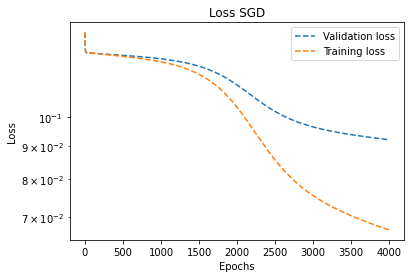

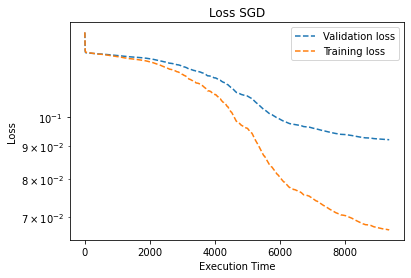

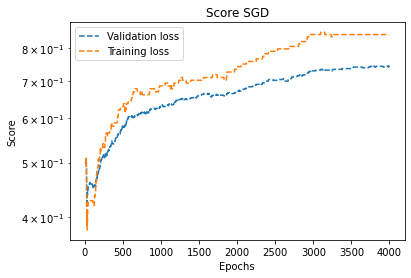

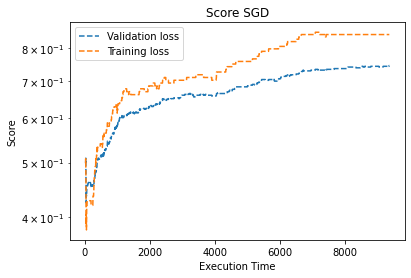

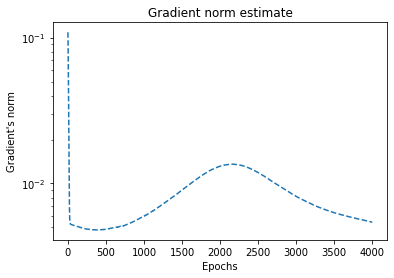

ep: 4000    | s: [16, 32] | b: 124 | e:  0.1 | lmbda: 0.01 | m:  0.5 | nesterov: False
Grad: 5.41681e-03 | Loss: 9.21630e-02, 6.68639e-02 | Score: 0.745, 0.847
ended in: 9361.689, avg per ep: 2.34042225
total update: 2640.292, avg updt: 0.660073
total ff: 12000, total ff time: 6426.721000000012, avg ff: 0.5355600833333344
total bp: 4000, total bp time: 1329.9660000000022, avg bp: 0.33249150000000055
total ev: 4000, total ev time: 6526.037, avg ev: 1.6315092500000001


----- SGD NAG -----
{'batch_size': None, 'epochs': 4000, 'eps': 1e-06, 'eta': 0.1, 'lmbda': 0.01, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [16, 32], 'debug': True, 'nesterov': True}


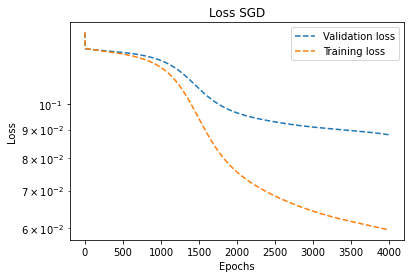

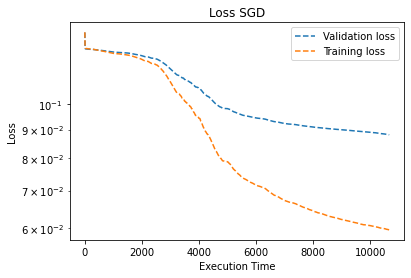

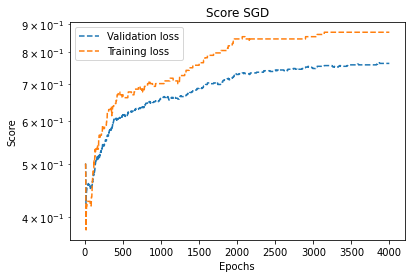

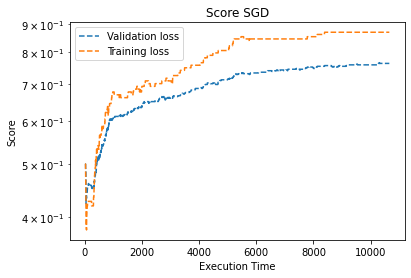

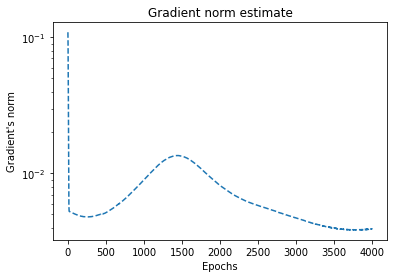

ep: 4000    | s: [16, 32] | b: 124 | e:  0.1 | lmbda: 0.01 | m:  0.5 | nesterov: True
Grad: 3.90829e-03 | Loss: 8.81313e-02, 5.95354e-02 | Score: 0.766, 0.871
ended in: 10657.521, avg per ep: 2.6643802500000002
total update: 3095.9060000000095, avg updt: 0.7739765000000024
total ff: 12000, total ff time: 7243.337000000042, avg ff: 0.6036114166666702
total bp: 4000, total bp time: 1457.7020000000007, avg bp: 0.3644255000000002
total ev: 4000, total ev time: 7364.41499999999, avg ev: 1.8411037499999976


----- Adam -----
{'batch_size': None, 'epochs': 4000, 'eps': 1e-06, 'eta': 0.1, 'lmbda': 0.01, 'optimizer': 'Adam', 'sizes': [16, 32], 'debug': True}


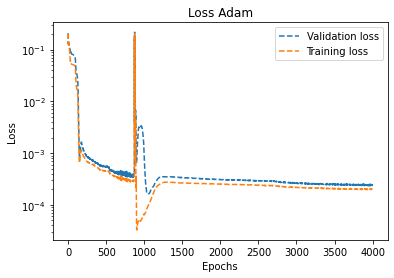

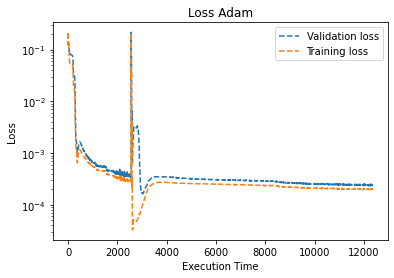

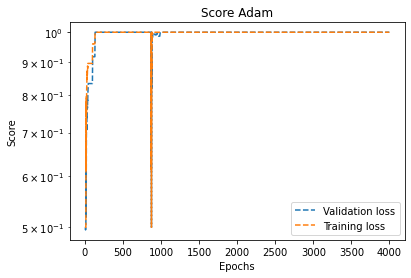

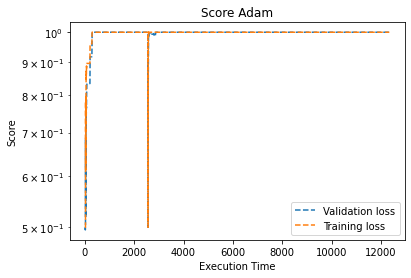

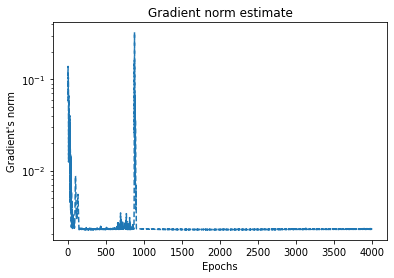

ep: 4000    | s: [16, 32] | b: 124 | e:  0.1 | lmbda: 0.01 | m:  0.5 | nesterov: False
Grad: 2.28390e-03 | Loss: 1.64430e-04, 9.85048e-05 | Score:     1, 1    
ended in: 12343.768, avg per ep: 3.085942
total update: 3519.2789999999995, avg updt: 0.8798197499999999
total ff: 12000, total ff time: 8471.620000000023, avg ff: 0.7059683333333352
total bp: 4000, total bp time: 1471.607999999998, avg bp: 0.36790199999999945
total ev: 4000, total ev time: 8598.614000000007, avg ev: 2.1496535000000017




<Figure size 432x288 with 0 Axes>

In [14]:
print("----- SGD CM -----")
plot_stats(sgd_cm, dataset, 'SGD', net_SGD)
print("----- SGD NAG -----")
plot_stats(sgd_nag, dataset, 'SGD', net_SGD_nest)
print("----- Adam -----")
plot_stats(adam, dataset, 'Adam', net_Adam)

### Monk2

In [15]:
dataset = 'monk2'
epochs = 4000

sgd_cm = params[dataset]['SGD'].copy()
sgd_cm['epochs'] = epochs

sgd_nag = sgd_cm.copy()
sgd_nag['nesterov'] = True
sgd_nag['epochs'] = epochs

adam = params[dataset]['Adam'].copy()
adam['epochs'] = epochs

monk2 = {
    'SGD': sgd_cm,
    'SGD_nest': sgd_nag,
    'Adam': adam
}
    
X_train, X_test, y_train, y_test = utils.load_monk(datasets['monk2'])
nn = NC
    
net_SGD = nn(**monk2['SGD'])
net_SGD.fit(X_train, y_train, test_data=(X_test, y_test))

net_SGD_nest = nn(**monk2['SGD_nest'])
net_SGD_nest.fit(X_train, y_train, test_data=(X_test, y_test))

net_Adam = nn(**monk2['Adam'])
net_Adam.fit(X_train, y_train, test_data=(X_test, y_test))

1       || Gradient norm: 2.02535e-01 || Loss: 1.55696e-01, 1.48889e-01 || Score: 0.329, 0.379
2       || Gradient norm: 1.94334e-01 || Loss: 1.48999e-01, 1.43342e-01 || Score: 0.329, 0.379
3       || Gradient norm: 1.80617e-01 || Loss: 1.42039e-01, 1.37691e-01 || Score: 0.329, 0.379
4       || Gradient norm: 1.63146e-01 || Loss: 1.35681e-01, 1.32664e-01 || Score: 0.329, 0.379
5       || Gradient norm: 1.43718e-01 || Loss: 1.30298e-01, 1.28546e-01 || Score: 0.329, 0.379
6       || Gradient norm: 1.24009e-01 || Loss: 1.25960e-01, 1.25360e-01 || Score: 0.412, 0.485
7       || Gradient norm: 1.05315e-01 || Loss: 1.22579e-01, 1.22994e-01 || Score: 0.664, 0.621
8       || Gradient norm: 8.84379e-02 || Loss: 1.19997e-01, 1.21287e-01 || Score: 0.671, 0.621
9       || Gradient norm: 7.37313e-02 || Loss: 1.18048e-01, 1.20080e-01 || Score: 0.671, 0.621
10      || Gradient norm: 6.12267e-02 || Loss: 1.16583e-01, 1.19236e-01 || Score: 0.671, 0.621
11      || Gradient norm: 5.07647e-02 || Loss: 1.1

NC(batch_size=169, debug=True, epochs=4000, eps=1e-06, lmbda=0.0,
   optimizer='Adam', sizes=[16, 32])

----- SGD CM -----
{'batch_size': None, 'epochs': 4000, 'eps': 1e-06, 'eta': 0.1, 'lmbda': 0.0, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [16, 32], 'debug': True}


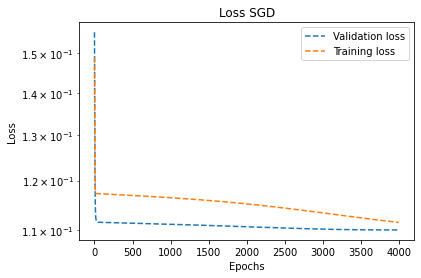

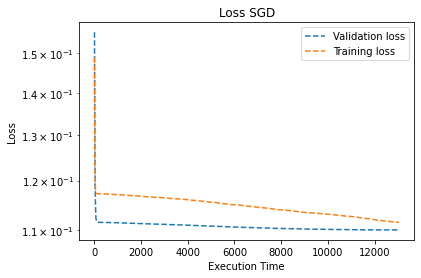

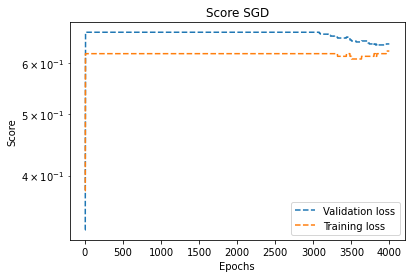

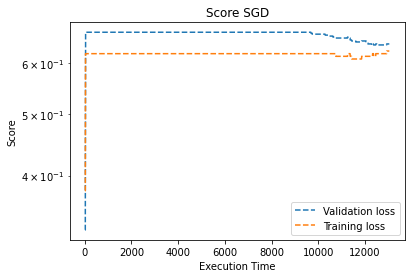

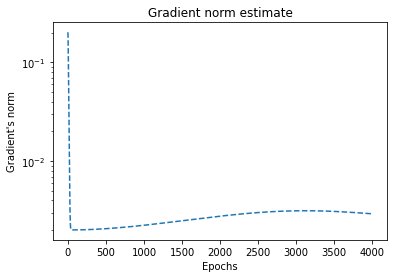

ep: 4000    | s: [16, 32] | b: 169 | e:  0.1 | lmbda:  0.0 | m:  0.5 | nesterov: False
Grad: 2.93198e-03 | Loss: 1.10057e-01, 1.11706e-01 | Score: 0.671, 0.621
ended in: 13037.352, avg per ep: 3.259338
total update: 3483.5999999999885, avg updt: 0.8708999999999971
total ff: 12000, total ff time: 9309.153999999997, avg ff: 0.7757628333333331
total bp: 4000, total bp time: 1778.1059999999984, avg bp: 0.4445264999999996
total ev: 4000, total ev time: 9361.026999999998, avg ev: 2.3402567499999996


----- SGD NAG -----
{'batch_size': None, 'epochs': 4000, 'eps': 1e-06, 'eta': 0.1, 'lmbda': 0.0, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [16, 32], 'debug': True, 'nesterov': True}


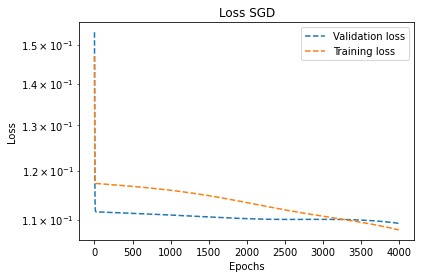

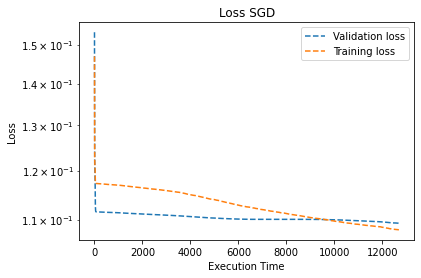

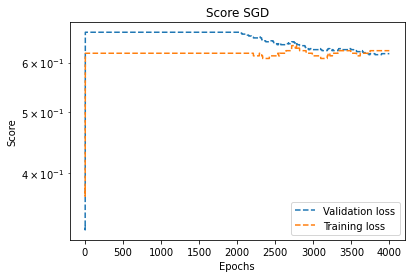

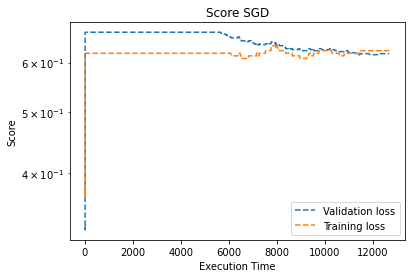

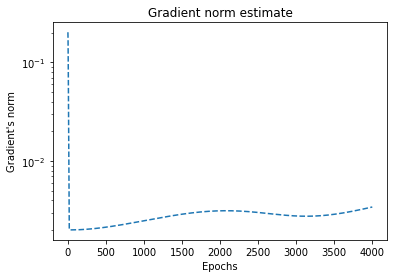

ep: 4000    | s: [16, 32] | b: 169 | e:  0.1 | lmbda:  0.0 | m:  0.5 | nesterov: True
Grad: 3.43516e-03 | Loss: 1.09307e-01, 1.08033e-01 | Score: 0.671, 0.621
ended in: 12688.137, avg per ep: 3.1720342500000003
total update: 3685.8810000000053, avg updt: 0.9214702500000014
total ff: 12000, total ff time: 8892.007000000038, avg ff: 0.7410005833333365
total bp: 4000, total bp time: 1755.7990000000013, avg bp: 0.43894975000000036
total ev: 4000, total ev time: 8807.483000000006, avg ev: 2.201870750000001


----- Adam -----
{'batch_size': None, 'epochs': 4000, 'eps': 1e-06, 'eta': 0.1, 'lmbda': 0.0, 'optimizer': 'Adam', 'sizes': [16, 32], 'debug': True}


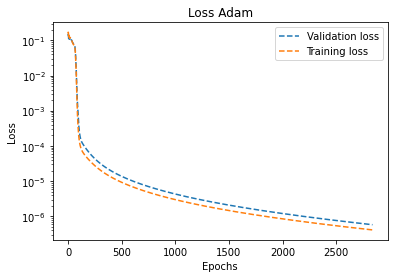

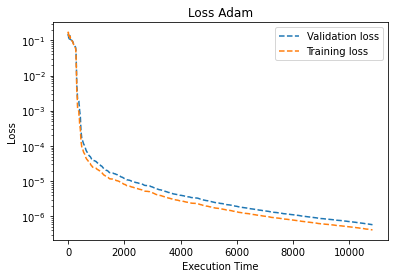

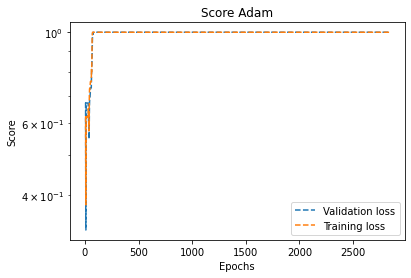

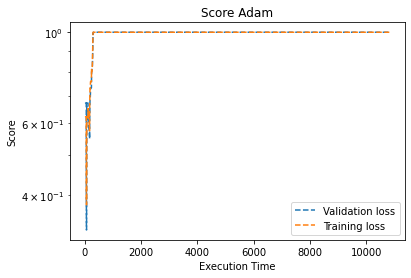

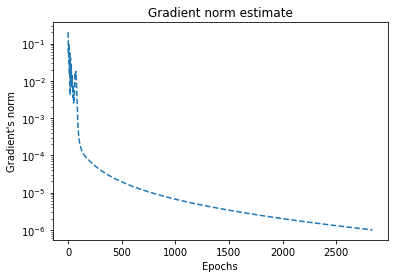

ep: 4000    | s: [16, 32] | b: 169 | e:  0.1 | lmbda:  0.0 | m:  0.5 | nesterov: False
Grad: 9.99342e-07 | Loss: 5.76724e-07, 4.10317e-07 | Score:     1, 1    
ended in: 10822.515, avg per ep: 2.70562875
total update: 3144.91799999999, avg updt: 0.7862294999999976
total ff: 8517, total ff time: 7597.456000000015, avg ff: 0.8920342843724334
total bp: 2839, total bp time: 1342.0089999999925, avg bp: 0.47270482564282934
total ev: 2839, total ev time: 7529.9400000000205, avg ev: 2.652321239873202




<Figure size 432x288 with 0 Axes>

In [16]:
print("----- SGD CM -----")
plot_stats(sgd_cm, dataset, 'SGD', net_SGD)
print("----- SGD NAG -----")
plot_stats(sgd_nag, dataset, 'SGD', net_SGD_nest)
print("----- Adam -----")
plot_stats(adam, dataset, 'Adam', net_Adam)

### Monk3

In [17]:
dataset = 'monk3'
epochs = 4000

sgd_cm = params[dataset]['SGD'].copy()
sgd_cm['epochs'] = epochs

sgd_nag = sgd_cm.copy()
sgd_nag['nesterov'] = True
sgd_nag['epochs'] = epochs

adam = params[dataset]['Adam'].copy()
adam['epochs'] = epochs

monk3 = {
    'SGD': sgd_cm,
    'SGD_nest': sgd_nag,
    'Adam': adam
}
    
X_train, X_test, y_train, y_test = utils.load_monk(datasets['monk3'])
nn = NC
    
net_SGD = nn(**monk3['SGD'])
net_SGD.fit(X_train, y_train, test_data=(X_test, y_test))

net_SGD_nest = nn(**monk3['SGD_nest'])
net_SGD_nest.fit(X_train, y_train, test_data=(X_test, y_test))

net_Adam = nn(**monk3['Adam'])
net_Adam.fit(X_train, y_train, test_data=(X_test, y_test))

1       || Gradient norm: 7.81688e-02 || Loss: 1.53195e-01, 1.45754e-01 || Score: 0.472, 0.508
2       || Gradient norm: 7.81022e-02 || Loss: 1.53087e-01, 1.45662e-01 || Score: 0.472, 0.508
3       || Gradient norm: 7.80019e-02 || Loss: 1.52963e-01, 1.45556e-01 || Score: 0.472, 0.508
4       || Gradient norm: 7.78843e-02 || Loss: 1.52829e-01, 1.45442e-01 || Score: 0.472, 0.508
5       || Gradient norm: 7.77577e-02 || Loss: 1.52691e-01, 1.45325e-01 || Score: 0.472, 0.508
6       || Gradient norm: 7.76261e-02 || Loss: 1.52552e-01, 1.45206e-01 || Score: 0.472, 0.508
7       || Gradient norm: 7.74917e-02 || Loss: 1.52412e-01, 1.45087e-01 || Score: 0.472, 0.508
8       || Gradient norm: 7.73555e-02 || Loss: 1.52272e-01, 1.44968e-01 || Score: 0.472, 0.508
9       || Gradient norm: 7.72180e-02 || Loss: 1.52132e-01, 1.44848e-01 || Score: 0.472, 0.508
10      || Gradient norm: 7.70796e-02 || Loss: 1.51992e-01, 1.44730e-01 || Score: 0.472, 0.508
11      || Gradient norm: 7.69403e-02 || Loss: 1.5

NC(batch_size=122, debug=True, epochs=4000, eps=1e-06, eta=0.01,
   optimizer='Adam', sizes=[5, 10])

----- SGD CM -----
{'batch_size': None, 'epochs': 4000, 'eps': 1e-06, 'eta': 0.01, 'lmbda': 0.0001, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [5, 10], 'debug': True}


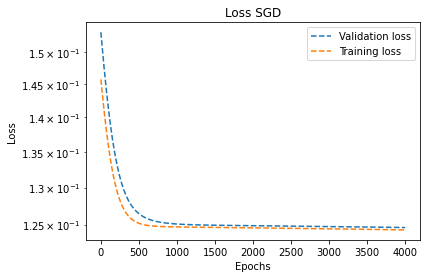

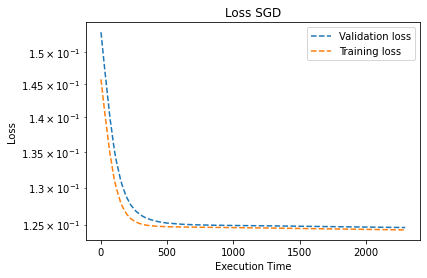

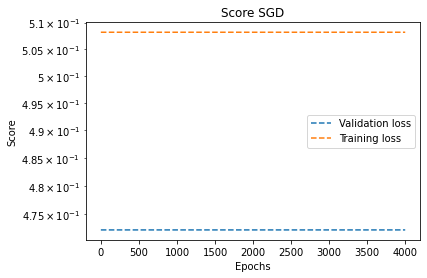

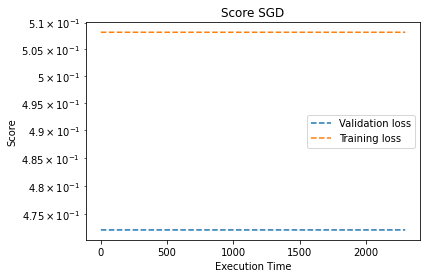

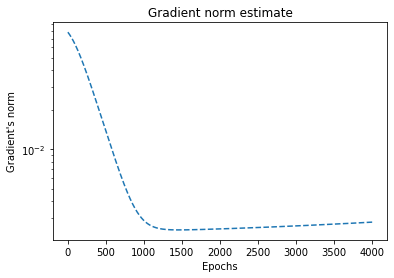

ep: 4000    | s: [5, 10] | b: 122 | e: 0.01 | lmbda:0.0001 | m:  0.5 | nesterov: False
Grad: 2.77163e-03 | Loss: 1.24620e-01, 1.24307e-01 | Score: 0.472, 0.508
ended in: 2295.36, avg per ep: 0.57384
total update: 1044.9470000000053, avg updt: 0.26123675000000135
total ff: 12000, total ff time: 891.2509999999734, avg ff: 0.07427091666666445
total bp: 4000, total bp time: 480.9370000000043, avg bp: 0.12023425000000107
total ev: 4000, total ev time: 1138.2480000000055, avg ev: 0.28456200000000137


----- SGD NAG -----
{'batch_size': None, 'epochs': 4000, 'eps': 1e-06, 'eta': 0.01, 'lmbda': 0.0001, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [5, 10], 'debug': True, 'nesterov': True}


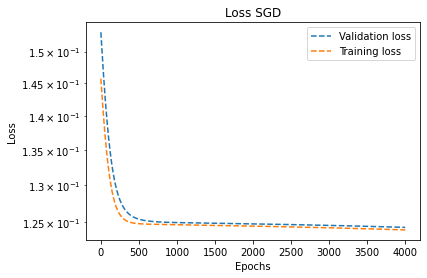

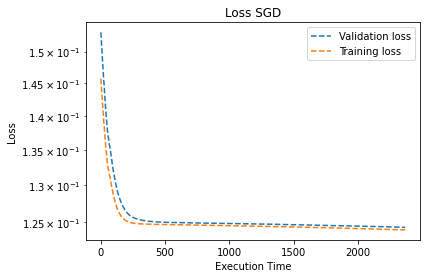

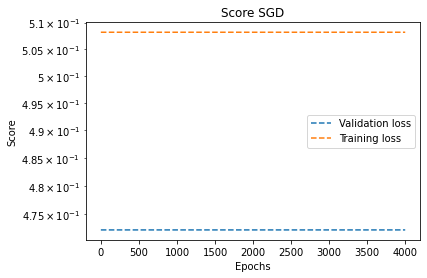

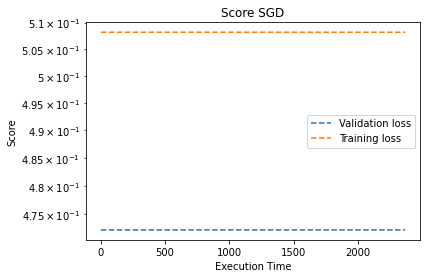

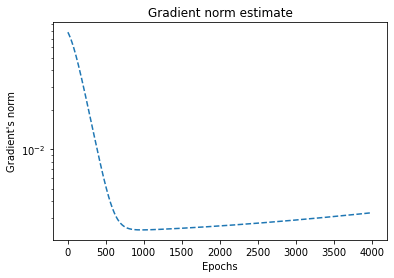

ep: 4000    | s: [5, 10] | b: 122 | e: 0.01 | lmbda:0.0001 | m:  0.5 | nesterov: True
Grad: 3.27136e-03 | Loss: 1.24283e-01, 1.23945e-01 | Score: 0.472, 0.508
ended in: 2365.616, avg per ep: 0.591404
total update: 1108.2619999999995, avg updt: 0.27706549999999985
total ff: 12000, total ff time: 895.0169999999857, avg ff: 0.07458474999999881
total bp: 4000, total bp time: 479.80300000000585, avg bp: 0.11995075000000147
total ev: 4000, total ev time: 1138.9000000000012, avg ev: 0.2847250000000003


----- Adam -----
{'batch_size': None, 'epochs': 4000, 'eps': 1e-06, 'eta': 0.01, 'lmbda': 0.0001, 'optimizer': 'Adam', 'sizes': [5, 10], 'debug': True}


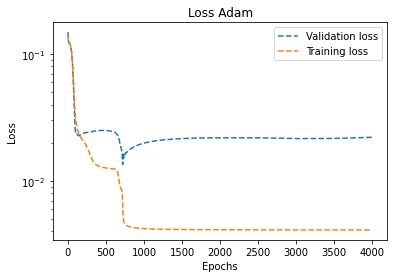

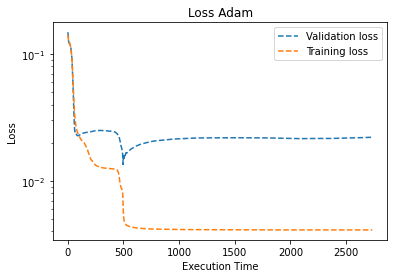

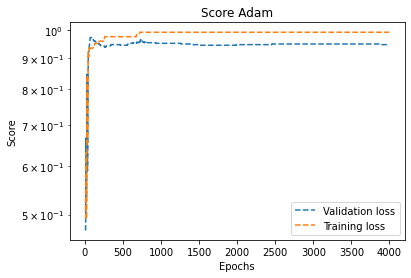

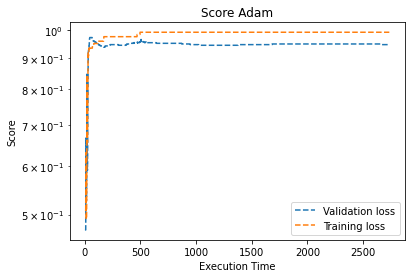

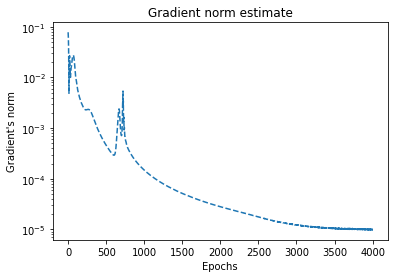

ep: 4000    | s: [5, 10] | b: 122 | e: 0.01 | lmbda:0.0001 | m:  0.5 | nesterov: False
Grad: 9.91152e-06 | Loss: 1.34809e-02, 6.43519e-03 | Score: 0.972, 0.934
ended in: 2735.691, avg per ep: 0.6839227499999999
total update: 1374.1359999999918, avg updt: 0.34353399999999795
total ff: 12000, total ff time: 958.6159999999943, avg ff: 0.07988466666666619
total bp: 4000, total bp time: 510.78500000000565, avg bp: 0.12769625000000143
total ev: 4000, total ev time: 1227.3549999999955, avg ev: 0.3068387499999989




<Figure size 432x288 with 0 Axes>

In [18]:
print("----- SGD CM -----")
plot_stats(sgd_cm, dataset, 'SGD', net_SGD)
print("----- SGD NAG -----")
plot_stats(sgd_nag, dataset, 'SGD', net_SGD_nest)
print("----- Adam -----")
plot_stats(adam, dataset, 'Adam', net_Adam)

### CUP

In [13]:
dataset = 'cup'

sgd_cm = params[dataset]['SGD'].copy()
sgd_nag = sgd_cm.copy()
sgd_nag['nesterov'] = True
adam = params[dataset]['Adam'].copy()

cup = {
    'SGD': sgd_cm,
    'SGD_nest': sgd_nag,
    'Adam': adam
}
    
X_train, X_test, y_train, y_test = utils.load_CUP(datasets['cup'])
nn = NR
    
net_SGD = nn(**cup['SGD'])
net_SGD.fit(X_train, y_train, test_data=(X_test, y_test))

net_SGD_nest = nn(**cup['SGD_nest'])
net_SGD_nest.fit(X_train, y_train, test_data=(X_test, y_test))

net_Adam = nn(**cup['Adam'])
net_Adam.fit(X_train, y_train, test_data=(X_test, y_test))

1       || Gradient norm: 2.04875e+02 || Loss: 8.09716e+02, 8.24768e+02 || Score: -8.07, -8.63
2       || Gradient norm: 2.12169e+02 || Loss: 7.66830e+02, 7.81122e+02 || Score: -7.59, -8.12
3       || Gradient norm: 2.37444e+02 || Loss: 6.93345e+02, 7.06000e+02 || Score: -6.77, -7.25
4       || Gradient norm: 2.96836e+02 || Loss: 5.63820e+02, 5.72697e+02 || Score: -5.34, -5.71
5       || Gradient norm: 3.99840e+02 || Loss: 3.33655e+02, 3.34430e+02 || Score: -2.81, -2.98
6       || Gradient norm: 4.85520e+02 || Loss: 8.44574e+01, 8.26024e+01 || Score: -0.129, -0.162
7       || Gradient norm: 1.74654e+02 || Loss: 3.96097e+02, 4.47560e+02 || Score: -3.64, -4.44
8       || Gradient norm: 1.78395e+03 || Loss: 9.26176e+01, 9.17392e+01 || Score: -0.0823, -0.125
9       || Gradient norm: 4.51393e+02 || Loss: 1.94920e+02, 1.85781e+02 || Score: -1.07, -1.06
10      || Gradient norm: 5.76012e+02 || Loss: 2.40226e+02, 2.43293e+02 || Score: -1.55, -1.7 
11      || Gradient norm: 4.28859e+02 || Loss

NR(batch_size=1066, debug=True, epochs=2000, eps=1e-06, eta=0.1, lmbda=0.01,
   optimizer='SGM', sizes=[16, 32])

----- SGD CM -----
{'batch_size': None, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.001, 'lmbda': 0.01, 'momentum': 0.9, 'optimizer': 'SGD', 'sizes': [16, 32], 'debug': True}


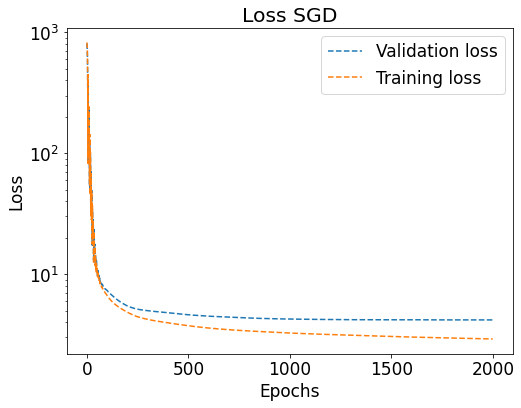

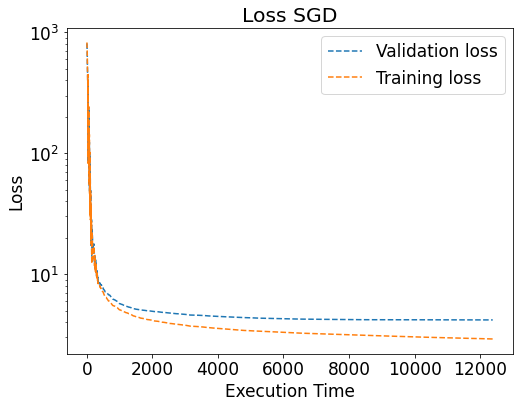

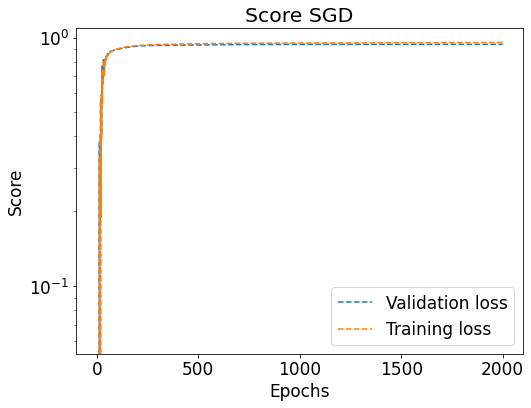

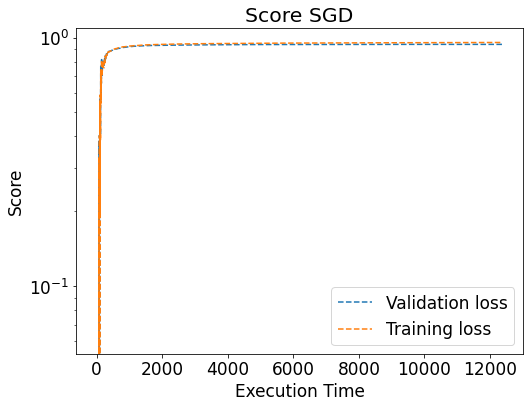

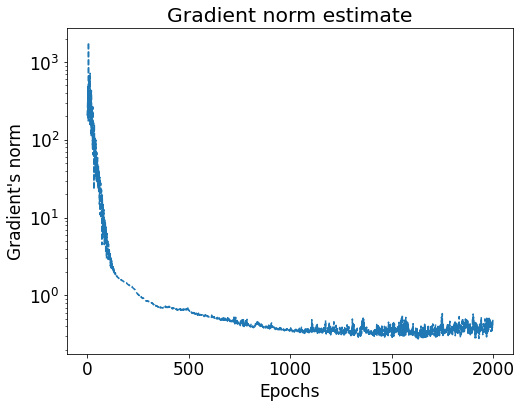

ep: 2000    | s: [16, 32] | b: 1066 | e:0.001 | lmbda: 0.01 | m:  0.9 | nesterov: False
Grad: 4.90515e-01 | Loss: 4.18102e+00, 2.91001e+00 | Score: 0.939, 0.953
ended in: 12381.74, avg per ep: 6.19087
total update: 5946.600999999992, avg updt: 2.973300499999996
total ff: 6000, total ff time: 6036.797999999999, avg ff: 1.0061329999999997
total bp: 2000, total bp time: 2931.356999999998, avg bp: 1.465678499999999
total ev: 2000, total ev time: 6301.145000000012, avg ev: 3.150572500000006


----- SGD NAG -----
{'batch_size': None, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.001, 'lmbda': 0.01, 'momentum': 0.9, 'optimizer': 'SGD', 'sizes': [16, 32], 'debug': True, 'nesterov': True}


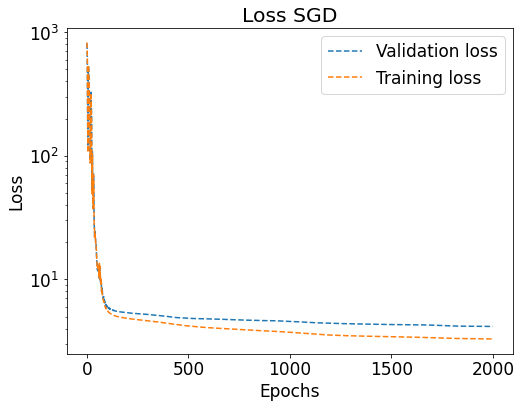

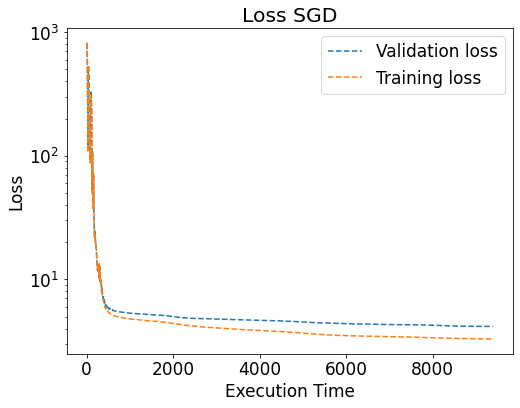

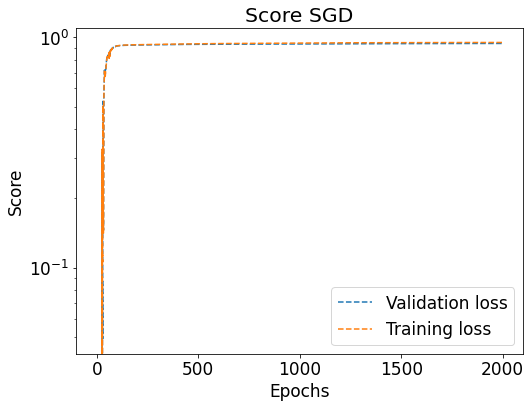

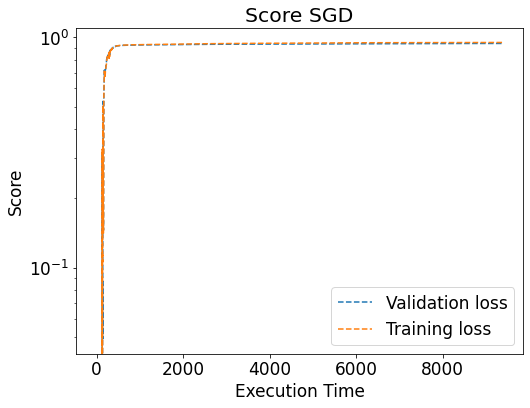

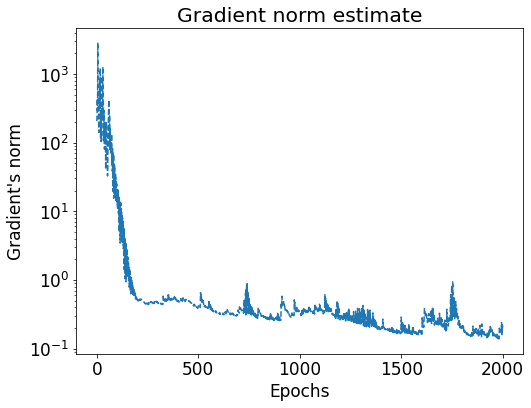

ep: 2000    | s: [16, 32] | b: 1066 | e:0.001 | lmbda: 0.01 | m:  0.9 | nesterov: True
Grad: 2.01574e-01 | Loss: 4.15687e+00, 3.29220e+00 | Score: 0.939, 0.949
ended in: 9386.372, avg per ep: 4.693186
total update: 4192.960999999998, avg updt: 2.0964804999999993
total ff: 6000, total ff time: 3954.2909999999833, avg ff: 0.6590484999999973
total bp: 2000, total bp time: 2103.6260000000016, avg bp: 1.0518130000000008
total ev: 2000, total ev time: 5057.497999999991, avg ev: 2.528748999999996


----- SGM -----
{'batch_size': None, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.1, 'lmbda': 0.01, 'optimizer': 'SGM', 'sizes': [16, 32], 'debug': True}


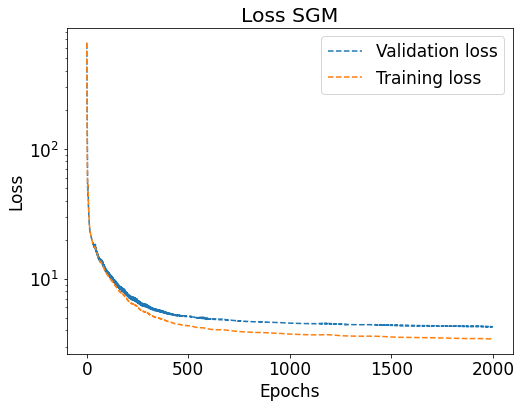

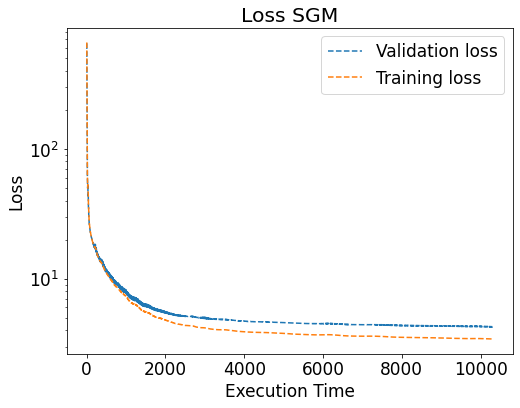

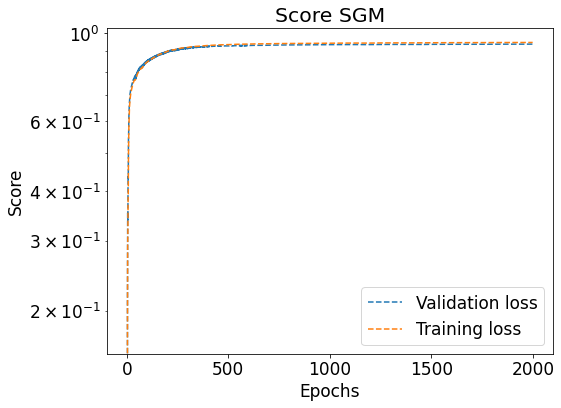

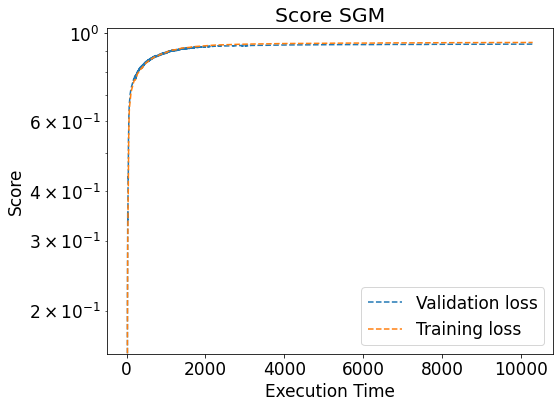

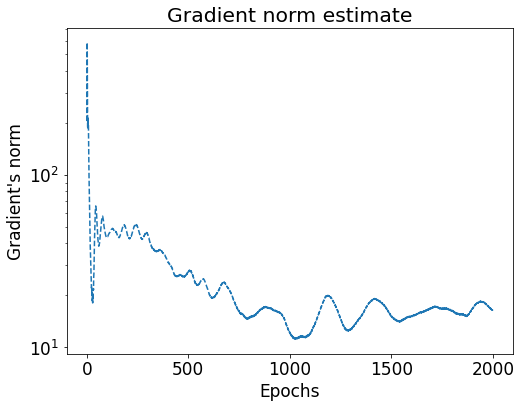

ep: 2000    | s: [16, 32] | b: 1066 | e:  0.1 | lmbda: 0.01 | m:  0.0 | nesterov: False
Grad: 1.62607e+01 | Loss: 4.24849e+00, 3.42971e+00 | Score: 0.939, 0.948
ended in: 10302.976, avg per ep: 5.1514880000000005
total update: 5209.108000000002, avg updt: 2.604554000000001
total ff: 6000, total ff time: 3882.480999999991, avg ff: 0.6470801666666652
total bp: 2000, total bp time: 3107.8109999999947, avg bp: 1.5539054999999973
total ev: 2000, total ev time: 4963.218999999981, avg ev: 2.4816094999999905




<Figure size 576x432 with 0 Axes>

In [14]:
print("----- SGD CM -----")
plot_stats(sgd_cm, dataset, 'SGD', net_SGD)
print("----- SGD NAG -----")
plot_stats(sgd_nag, dataset, 'SGD', net_SGD_nest)
print("----- Adam -----")
plot_stats(adam, dataset, 'Adam', net_Adam)

# Report stats

## Monk1

In [17]:
debug = False
score = False
dataset = 'monk1'
net_SGD, net_SGD_nest, net_Adam = report_stats(params, dataset, score=score, debug=debug)

----- SGD -----
{'batch_size': None, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.1, 'lmbda': 0.01, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [16, 32], 'debug': True}
ep: 2000    | s: [16, 32] | b: 124 | e:  0.1 | lmbda: 0.01 | m:  0.5 | nesterov: False
Grad: 2.56263e-03 | Loss: 2.31608e-03, 7.12821e-04 | Score:     1, 1    
ended in: 2374.83, avg per ep: 1.1874149999999999
total update: 907.8470000000104, avg updt: 0.4539235000000052
total ff: 6000, total ff time: 1322.8579999999654, avg ff: 0.22047633333332756
total bp: 2000, total bp time: 393.9419999999987, avg bp: 0.19697099999999934
total ev: 2000, total ev time: 1385.5800000000004, avg ev: 0.6927900000000002

 

----- SGD nesterov-----
{'batch_size': None, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.1, 'lmbda': 0.01, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [16, 32], 'debug': True}
ep: 2000    | s: [16, 32] | b: 124 | e:  0.1 | lmbda: 0.01 | m:  0.5 | nesterov: True
Grad: 1.56916e-03 | Loss: 1.39298e-03, 4.09415e-04 | Score:     1

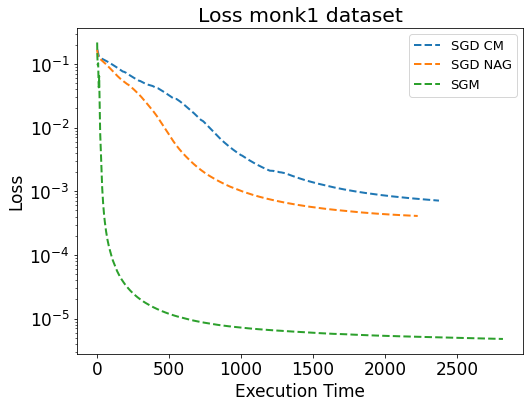

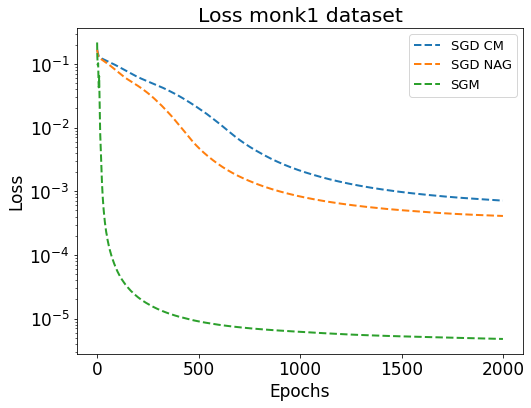

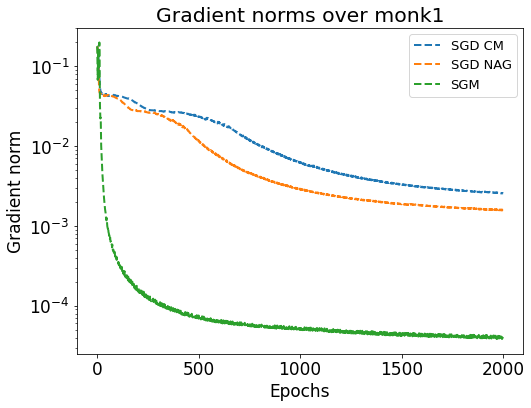

<Figure size 576x432 with 0 Axes>

In [18]:
report_plots(params, dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_Adam=net_Adam, score=score)

## Monk2

In [43]:
debug = False
score = False
dataset = 'monk2'
net_SGD, net_SGD_nest, net_Adam = report_stats(params, dataset, score=score, debug=debug)

----- SGD -----
{'batch_size': None, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.1, 'lmbda': 0.0, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [16, 32], 'debug': True}
ep: 2000    | s: [16, 32] | b: 169 | e:  0.1 | lmbda:  0.0 | m:  0.5 | nesterov: False
Grad: 1.30885e-03 | Loss: 4.82401e-04, 3.65383e-04 | Score:     1, 1    
ended in: 2663.161, avg per ep: 1.3315805
total update: 1036.1329999999919, avg updt: 0.5180664999999959
total ff: 6000, total ff time: 1528.248999999974, avg ff: 0.25470816666666235
total bp: 2000, total bp time: 469.0580000000031, avg bp: 0.23452900000000157
total ev: 2000, total ev time: 1544.8599999999972, avg ev: 0.7724299999999986

 

----- SGD nesterov-----
{'batch_size': None, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.1, 'lmbda': 0.0, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [16, 32], 'debug': True}
ep: 2000    | s: [16, 32] | b: 169 | e:  0.1 | lmbda:  0.0 | m:  0.5 | nesterov: True
Grad: 7.00408e-04 | Loss: 2.42000e-04, 1.81363e-04 | Score:     1, 1    
en

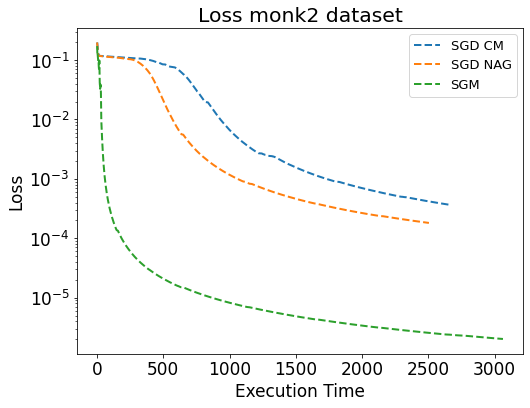

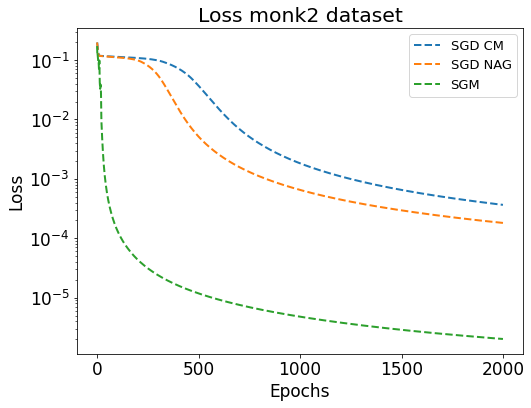

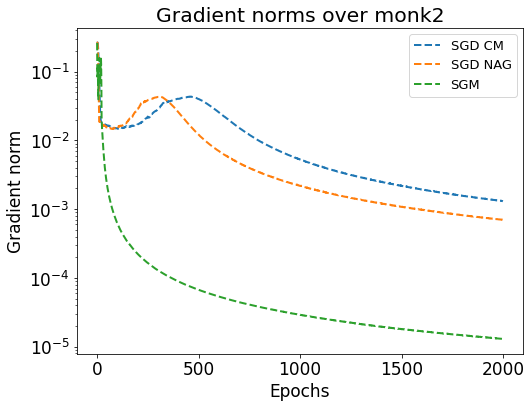

<Figure size 576x432 with 0 Axes>

In [44]:
report_plots(params, dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_Adam=net_Adam, score=score)

## Monk3

In [45]:
debug = False
score = False
dataset = 'monk3'
net_SGD, net_SGD_nest, net_Adam = report_stats(params, dataset, score=score, debug=debug)

----- SGD -----
{'batch_size': None, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.01, 'lmbda': 0.0001, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [5, 10], 'debug': True}
ep: 2000    | s: [5, 10] | b: 122 | e: 0.01 | lmbda:0.0001 | m:  0.5 | nesterov: False
Grad: 3.82696e-02 | Loss: 4.04101e-02, 4.55686e-02 | Score: 0.965, 0.934
ended in: 1291.288, avg per ep: 0.645644
total update: 561.3490000000069, avg updt: 0.28067450000000344
total ff: 6000, total ff time: 512.8310000000191, avg ff: 0.08547183333333652
total bp: 2000, total bp time: 209.09999999999863, avg bp: 0.10454999999999931
total ev: 2000, total ev time: 651.440000000006, avg ev: 0.325720000000003

 

----- SGD nesterov-----
{'batch_size': None, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.01, 'lmbda': 0.0001, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [5, 10], 'debug': True}
ep: 2000    | s: [5, 10] | b: 122 | e: 0.01 | lmbda:0.0001 | m:  0.5 | nesterov: True
Grad: 1.67891e-02 | Loss: 2.29421e-02, 3.17960e-02 | Score: 0.972, 0.934

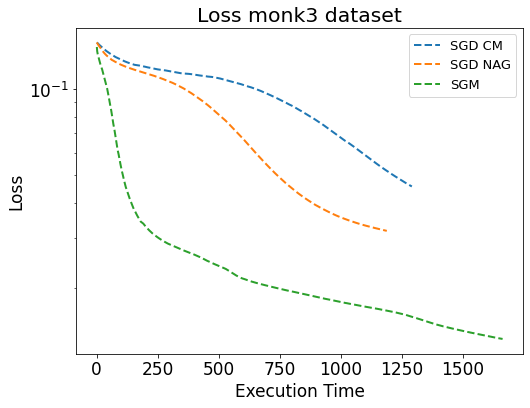

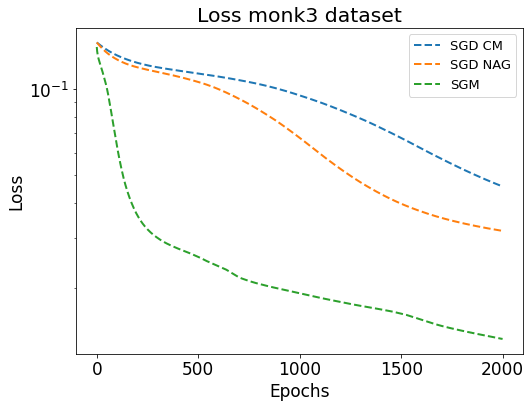

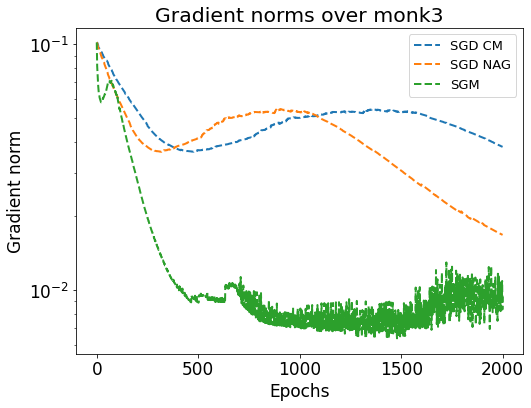

<Figure size 576x432 with 0 Axes>

In [46]:
report_plots(params, dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_Adam=net_Adam, score=score)

## CUP

In [7]:
debug = False
score = False
dataset = 'cup'
net_SGD, net_SGD_nest, net_Adam = report_stats(params, dataset, score=score, debug=debug)

----- SGD -----
{'batch_size': None, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.001, 'lmbda': 0.01, 'momentum': 0.9, 'optimizer': 'SGD', 'sizes': [16, 32], 'debug': True}
ep: 2000    | s: [16, 32] | b: 1066 | e:0.001 | lmbda: 0.01 | m:  0.9 | nesterov: False
Grad: 4.90515e-01 | Loss: 4.18102e+00, 2.91001e+00 | Score: 0.939, 0.953
ended in: 7801.508, avg per ep: 3.900754
total update: 3774.1259999999993, avg updt: 1.8870629999999997
total ff: 6000, total ff time: 3810.7889999999998, avg ff: 0.6351315
total bp: 2000, total bp time: 1907.1319999999973, avg bp: 0.9535659999999987
total ev: 2000, total ev time: 3936.5970000000025, avg ev: 1.9682985000000013

 

----- SGD nesterov-----
{'batch_size': None, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.001, 'lmbda': 0.01, 'momentum': 0.9, 'optimizer': 'SGD', 'sizes': [16, 32], 'debug': True}
ep: 2000    | s: [16, 32] | b: 1066 | e:0.001 | lmbda: 0.01 | m:  0.9 | nesterov: True
Grad: 2.01574e-01 | Loss: 4.15687e+00, 3.29220e+00 | Score: 0.939, 0.949
ende

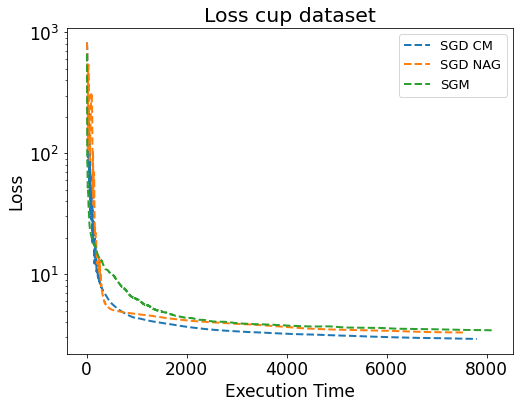

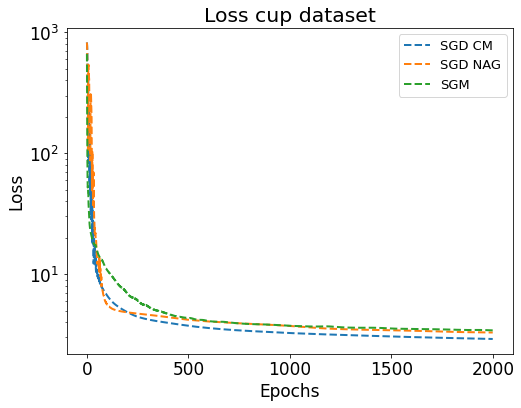

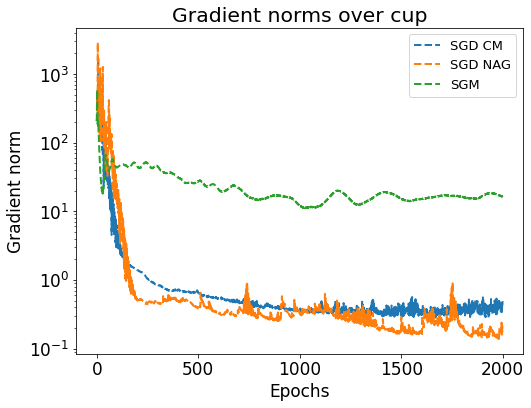

<Figure size 576x432 with 0 Axes>

In [8]:
report_plots(params, dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_Adam=net_Adam, score=score)

----- SGD -----
{'batch_size': None, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.001, 'lmbda': 0.01, 'momentum': 0.9, 'optimizer': 'SGD', 'sizes': [16, 32], 'debug': True}
ep: 2000    | s: [16, 32] | b: 1066 | e:0.001 | lmbda: 0.01 | m:  0.9 | nesterov: False
Grad: 4.90515e-01 | Loss: 4.18102e+00, 2.91001e+00 | Score: 0.939, 0.953
ended in: 8192.183, avg per ep: 4.096091500000001
total update: 3733.0669999999973, avg updt: 1.8665334999999987
total ff: 6000, total ff time: 3958.878000000001, avg ff: 0.6598130000000002
total bp: 2000, total bp time: 1870.1730000000007, avg bp: 0.9350865000000004
total ev: 2000, total ev time: 4353.712, avg ev: 2.1768560000000003

 

----- SGD nesterov-----
{'batch_size': None, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.001, 'lmbda': 0.01, 'momentum': 0.9, 'optimizer': 'SGD', 'sizes': [16, 32], 'debug': True}
ep: 2000    | s: [16, 32] | b: 1066 | e:0.001 | lmbda: 0.01 | m:  0.9 | nesterov: True
Grad: 2.01574e-01 | Loss: 4.15687e+00, 3.29220e+00 | Score: 0.939, 0.9

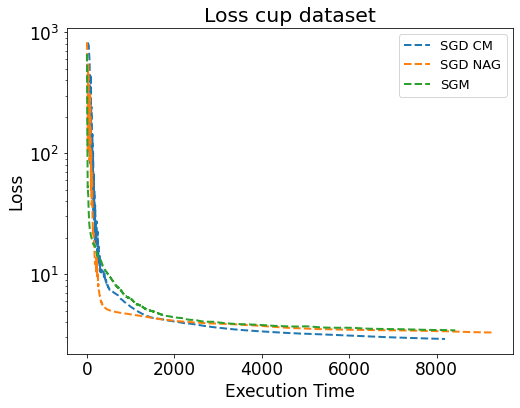

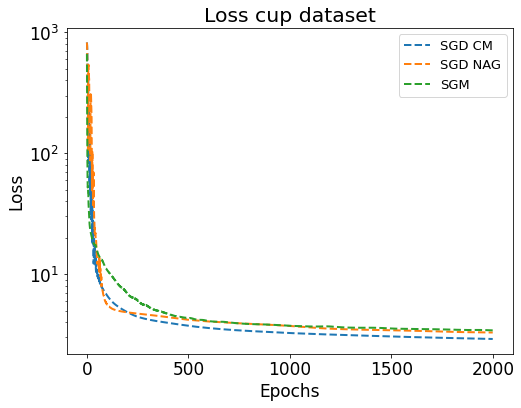

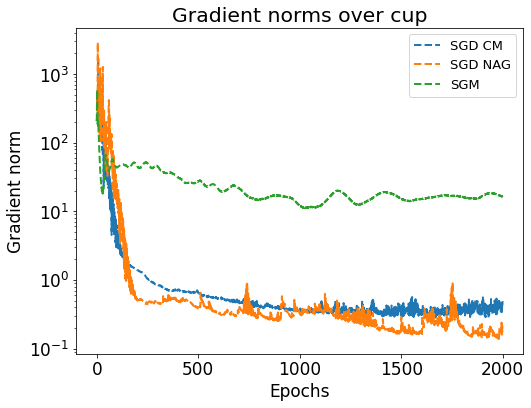

<Figure size 576x432 with 0 Axes>

In [28]:
report_plots(params, dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_Adam=net_Adam, score=score)

# Test convergence to given precision

In [47]:
params_conv = params.copy()

### Monk1

In [48]:
debug = False
score = False
dataset = 'monk1'

epochs = 10000
eps = 1e-3

sgd_cm = params[dataset]['SGD'].copy()
sgd_cm['eta'] = 0.8
sgd_cm['epochs'] = epochs
sgd_cm['eps'] = eps
sgd_cm['lmbda'] = 0

sgd_nag = sgd_cm.copy()
sgd_nag['eta'] = 0.8
sgd_nag['nesterov'] = True
sgd_nag['epochs'] = epochs
sgd_nag['eps'] = eps
sgd_nag['lmbda'] = 0

adam = params[dataset]['Adam'].copy()
adam['epochs'] = epochs
adam['eps'] = eps
adam['lmbda'] = 0

monk1 = {
    'SGD': sgd_cm,
    'SGD_nest': sgd_nag,
    'Adam': adam
}

net_cm, net_nag, net_adam = convergence_test(dataset, monk1)

1       || Gradient norm: 1.78253e-01 || Loss: 1.43051e-01, 1.47069e-01 || Score:   0.5, 0.5  
2       || Gradient norm: 1.51336e-01 || Loss: 1.25089e-01, 1.28115e-01 || Score: 0.539, 0.476
3       || Gradient norm: 5.48934e-02 || Loss: 1.26514e-01, 1.27982e-01 || Score: 0.502, 0.516
4       || Gradient norm: 8.71279e-02 || Loss: 1.24523e-01, 1.24630e-01 || Score: 0.514, 0.532
5       || Gradient norm: 8.17930e-02 || Loss: 1.20497e-01, 1.19301e-01 || Score: 0.595, 0.597
6       || Gradient norm: 4.60840e-02 || Loss: 1.19112e-01, 1.16591e-01 || Score: 0.613, 0.637
7       || Gradient norm: 4.74586e-02 || Loss: 1.17708e-01, 1.13893e-01 || Score: 0.613, 0.653
8       || Gradient norm: 4.80254e-02 || Loss: 1.15938e-01, 1.10848e-01 || Score: 0.662, 0.758
9       || Gradient norm: 4.17729e-02 || Loss: 1.14496e-01, 1.08270e-01 || Score: 0.657, 0.758
10      || Gradient norm: 4.19566e-02 || Loss: 1.13024e-01, 1.05659e-01 || Score: 0.657, 0.766
11      || Gradient norm: 4.26386e-02 || Loss: 1.1

{'batch_size': None, 'epochs': 10000, 'eps': 0.001, 'eta': 0.8, 'lmbda': 0, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [16, 32], 'debug': True}


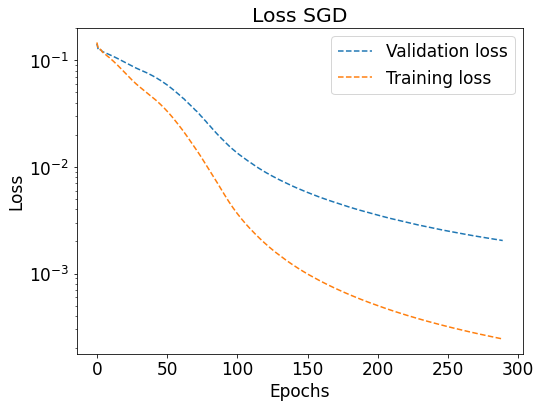

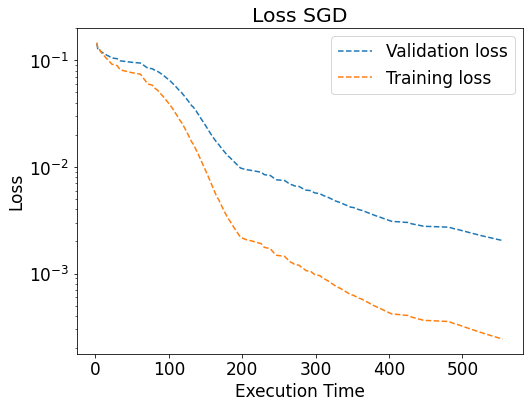

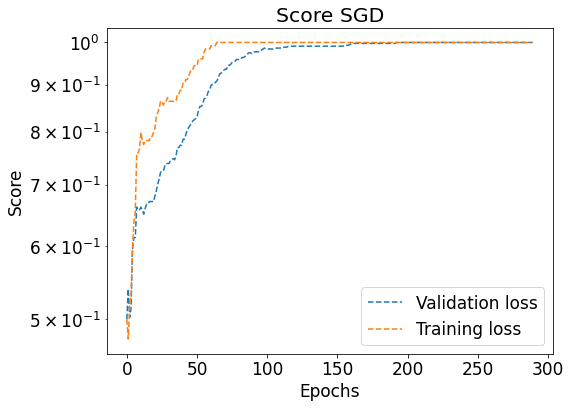

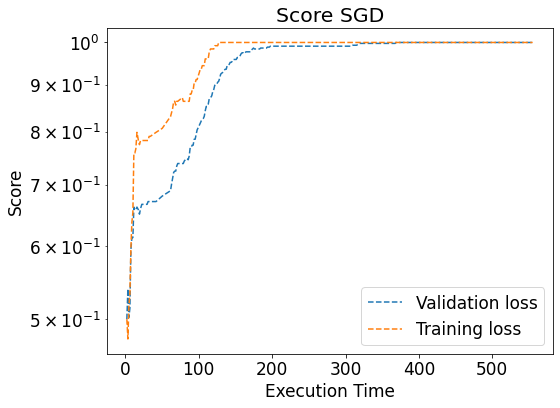

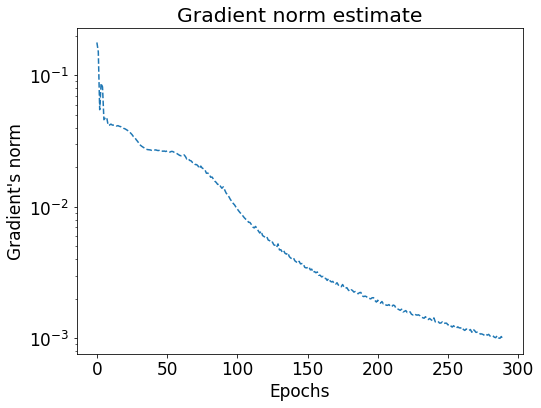

ep: 10000   | s: [16, 32] | b: 124 | e:  0.8 | lmbda:    0 | m:  0.5 | nesterov: False
Grad: 9.89515e-04 | Loss: 2.04178e-03, 2.43510e-04 | Score:     1, 1    
ended in: 555.067, avg per ep: 0.0555067
total update: 143.865, avg updt: 0.014386500000000002
total ff: 870, total ff time: 324.9559999999997, avg ff: 0.37351264367816056
total bp: 290, total bp time: 60.083000000000084, avg bp: 0.20718275862068994
total ev: 290, total ev time: 397.04600000000005, avg ev: 1.3691241379310346


{'batch_size': None, 'epochs': 10000, 'eps': 0.001, 'eta': 0.8, 'lmbda': 0, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [16, 32], 'debug': True, 'nesterov': True}


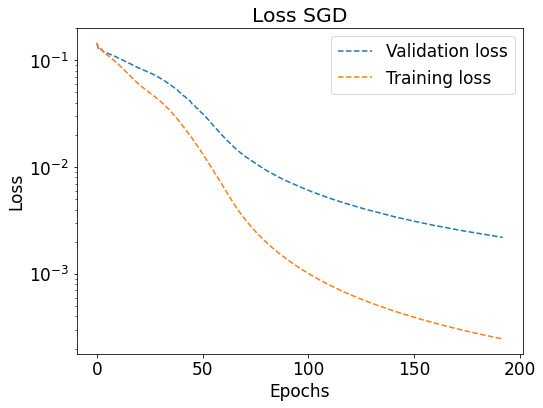

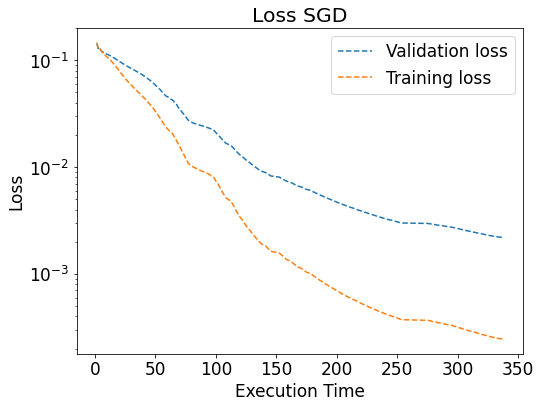

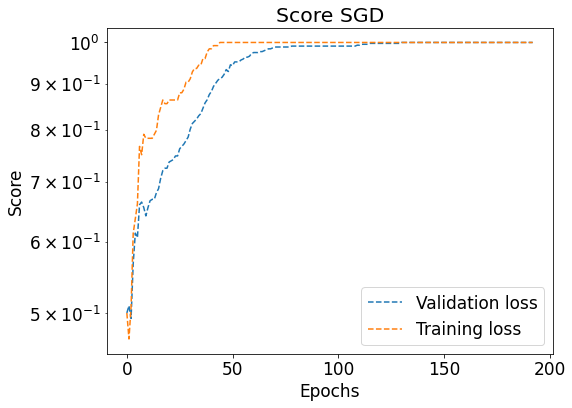

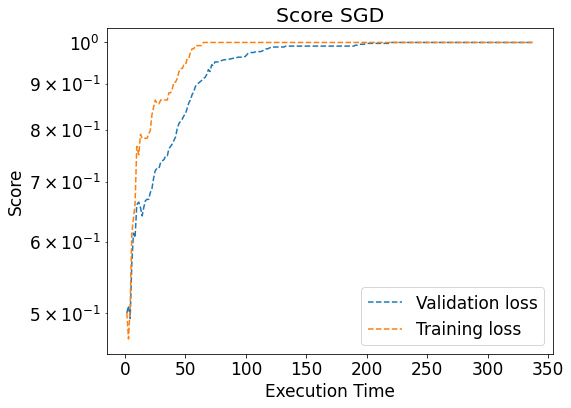

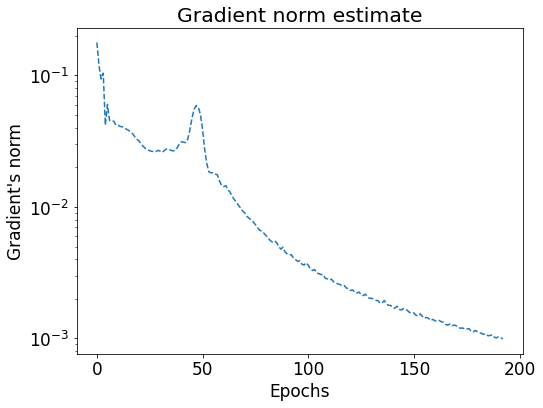

ep: 10000   | s: [16, 32] | b: 124 | e:  0.8 | lmbda:    0 | m:  0.5 | nesterov: True
Grad: 9.91275e-04 | Loss: 2.19657e-03, 2.45705e-04 | Score:     1, 1    
ended in: 337.41, avg per ep: 0.033741
total update: 101.37600000000006, avg updt: 0.010137600000000007
total ff: 579, total ff time: 178.47499999999977, avg ff: 0.3082469775474953
total bp: 193, total bp time: 40.09600000000004, avg bp: 0.20775129533678777
total ev: 193, total ev time: 226.58599999999996, avg ev: 1.1740207253886008


{'batch_size': None, 'epochs': 10000, 'eps': 0.001, 'eta': 0.1, 'lmbda': 0, 'optimizer': 'SGM', 'sizes': [16, 32], 'debug': True}


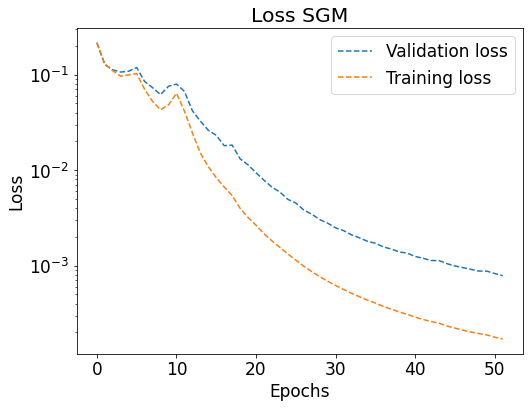

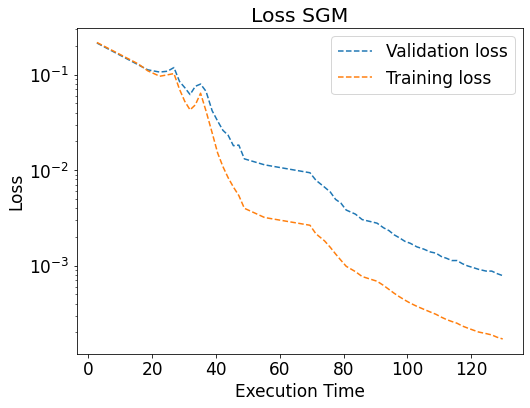

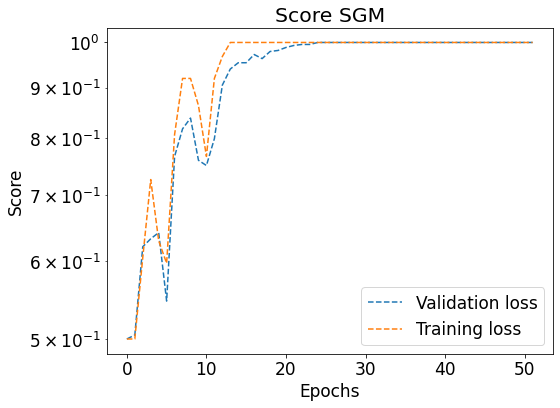

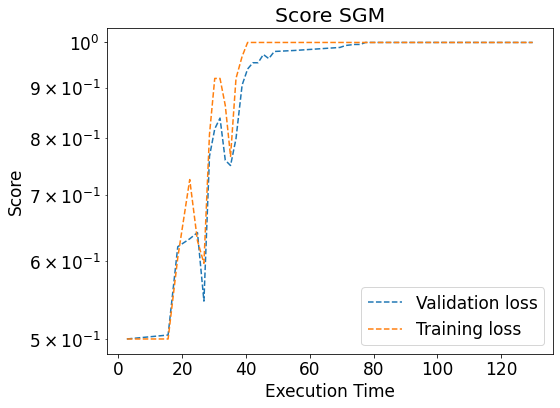

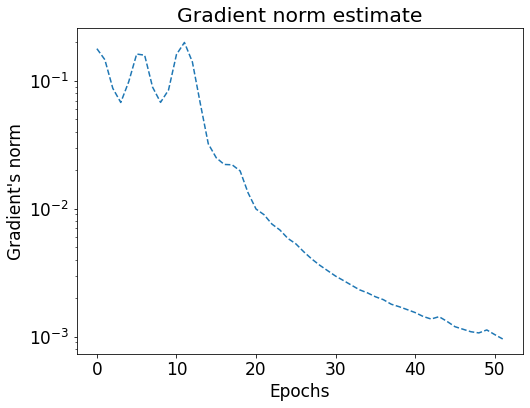

ep: 10000   | s: [16, 32] | b: 124 | e:  0.1 | lmbda:    0 | m:  0.5 | nesterov: False
Grad: 9.56791e-04 | Loss: 7.86391e-04, 1.70774e-04 | Score:     1, 1    
ended in: 130.027, avg per ep: 0.013002699999999999
total update: 44.74999999999999, avg updt: 0.004474999999999999
total ff: 156, total ff time: 66.766, avg ff: 0.4279871794871795
total bp: 52, total bp time: 25.528999999999996, avg bp: 0.4909423076923076
total ev: 52, total ev time: 82.19299999999996, avg ev: 1.5806346153846145




<Figure size 576x432 with 0 Axes>

In [49]:
plot_stats(sgd_cm, dataset=dataset, test='SGD', net=net_cm, log=True)
plot_stats(sgd_nag, dataset=dataset, test='SGD', net=net_nag, log=True)
plot_stats(adam, dataset=dataset, test='Adam', net=net_adam, log=True)

----- SGD -----
{'batch_size': None, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.1, 'lmbda': 0.01, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [16, 32], 'debug': True}
ep: 10000   | s: [16, 32] | b: 124 | e:  0.8 | lmbda:    0 | m:  0.5 | nesterov: False
Grad: 9.89515e-04 | Loss: 2.04178e-03, 2.43510e-04 | Score:     1, 1    
ended in: 555.067, avg per ep: 0.0555067
total update: 143.865, avg updt: 0.014386500000000002
total ff: 870, total ff time: 324.9559999999997, avg ff: 0.37351264367816056
total bp: 290, total bp time: 60.083000000000084, avg bp: 0.20718275862068994
total ev: 290, total ev time: 397.04600000000005, avg ev: 1.3691241379310346

 

----- SGD nesterov-----
{'batch_size': None, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.1, 'lmbda': 0.01, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [16, 32], 'debug': True}
ep: 10000   | s: [16, 32] | b: 124 | e:  0.8 | lmbda:    0 | m:  0.5 | nesterov: True
Grad: 9.91275e-04 | Loss: 2.19657e-03, 2.45705e-04 | Score:     1, 1    
ended in: 33

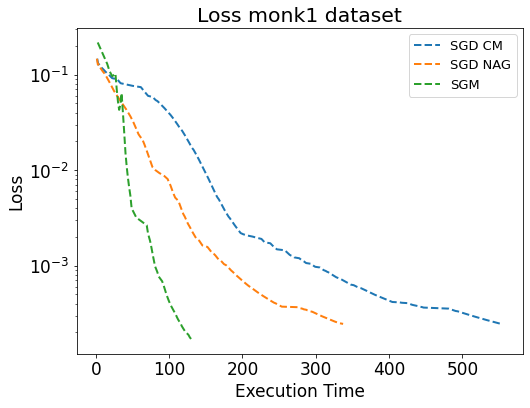

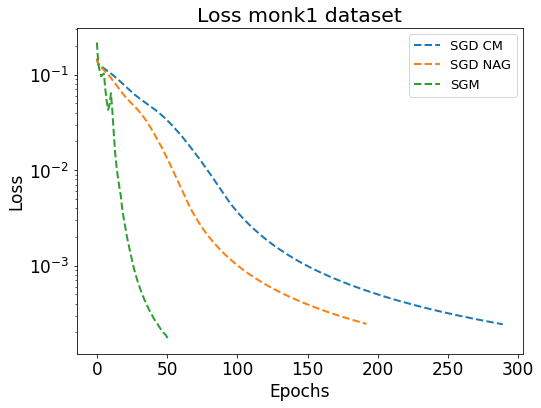

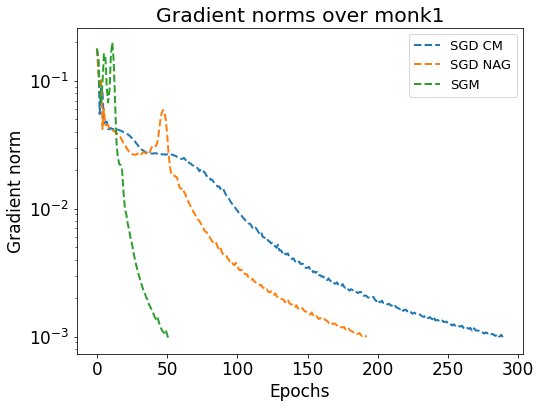

<Figure size 576x432 with 0 Axes>

In [50]:
report_plots(params_conv, dataset, net_SGD=net_cm, net_SGD_nest=net_nag, net_Adam=net_adam, score=score)

### Monk2

In [51]:
debug = False
score = False
dataset = 'monk2'

epochs = 10000
eps = 1e-3

sgd_cm = params[dataset]['SGD'].copy()
sgd_cm['eta'] = 0.8
sgd_cm['epochs'] = epochs
sgd_cm['eps'] = eps

sgd_nag = sgd_cm.copy()
sgd_nag['eta'] = 0.8
sgd_nag['nesterov'] = True
sgd_nag['epochs'] = epochs
sgd_nag['eps'] = eps

adam = params[dataset]['Adam'].copy()
adam['epochs'] = epochs
adam['eps'] = eps

monk2 = {
    'SGD': sgd_cm,
    'SGD_nest': sgd_nag,
    'Adam': adam
}

net_cm, net_nag, net_adam = convergence_test(dataset, monk2)

1       || Gradient norm: 2.60753e-01 || Loss: 1.61126e-01, 1.51250e-01 || Score: 0.331, 0.385
2       || Gradient norm: 2.24112e-01 || Loss: 1.13211e-01, 1.17949e-01 || Score: 0.667, 0.615
3       || Gradient norm: 1.90443e-02 || Loss: 1.12912e-01, 1.23931e-01 || Score: 0.671, 0.621
4       || Gradient norm: 8.89743e-02 || Loss: 1.12471e-01, 1.23121e-01 || Score: 0.671, 0.621
5       || Gradient norm: 8.60818e-02 || Loss: 1.10779e-01, 1.18107e-01 || Score: 0.671, 0.621
6       || Gradient norm: 4.81954e-02 || Loss: 1.12369e-01, 1.16151e-01 || Score: 0.671, 0.627
7       || Gradient norm: 1.77854e-02 || Loss: 1.14129e-01, 1.16185e-01 || Score: 0.639, 0.58 
8       || Gradient norm: 3.22172e-02 || Loss: 1.13415e-01, 1.15581e-01 || Score:  0.65, 0.592
9       || Gradient norm: 2.81358e-02 || Loss: 1.11837e-01, 1.14843e-01 || Score: 0.671, 0.627
10      || Gradient norm: 1.73785e-02 || Loss: 1.10819e-01, 1.14427e-01 || Score: 0.669, 0.621
11      || Gradient norm: 1.66071e-02 || Loss: 1.1

{'batch_size': None, 'epochs': 10000, 'eps': 0.001, 'eta': 0.8, 'lmbda': 0.0, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [16, 32], 'debug': True}


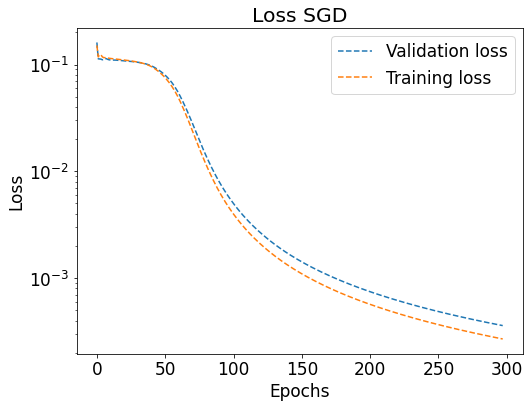

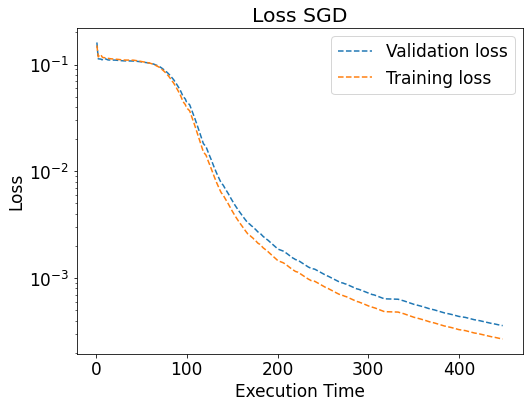

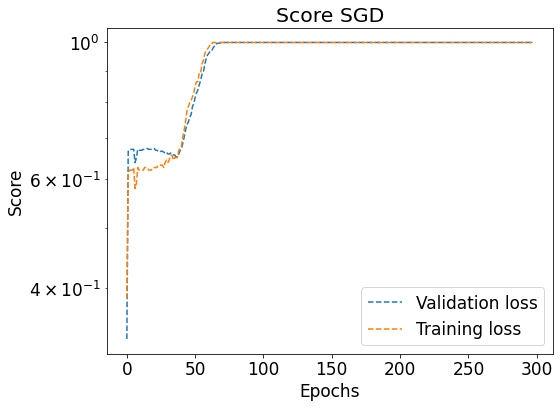

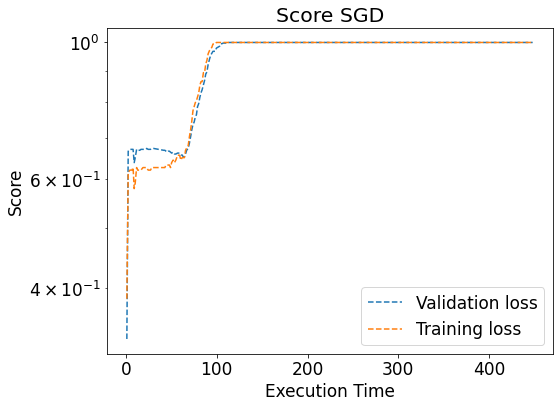

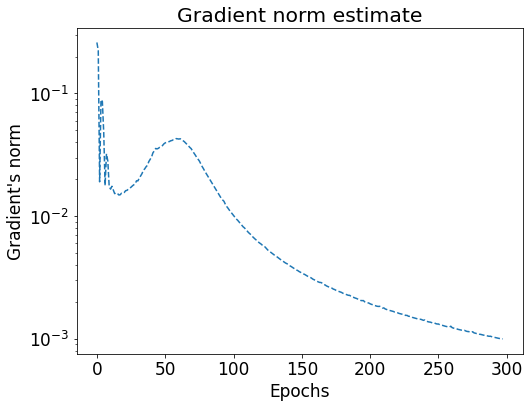

ep: 10000   | s: [16, 32] | b: 169 | e:  0.8 | lmbda:  0.0 | m:  0.5 | nesterov: False
Grad: 9.95147e-04 | Loss: 3.58341e-04, 2.68525e-04 | Score:     1, 1    
ended in: 448.131, avg per ep: 0.044813099999999995
total update: 146.78899999999987, avg updt: 0.014678899999999988
total ff: 894, total ff time: 232.2639999999996, avg ff: 0.25980313199105104
total bp: 298, total bp time: 63.68600000000012, avg bp: 0.21371140939597355
total ev: 298, total ev time: 288.57599999999974, avg ev: 0.9683758389261736


{'batch_size': None, 'epochs': 10000, 'eps': 0.001, 'eta': 0.8, 'lmbda': 0.0, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [16, 32], 'debug': True, 'nesterov': True}


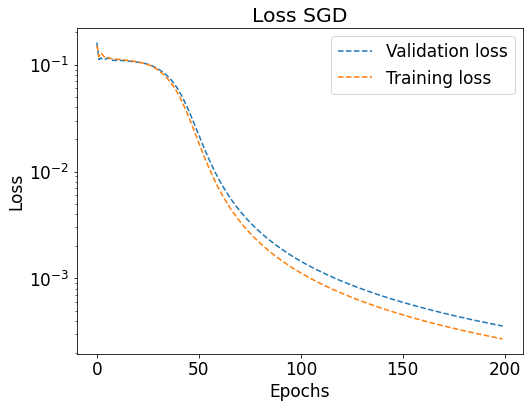

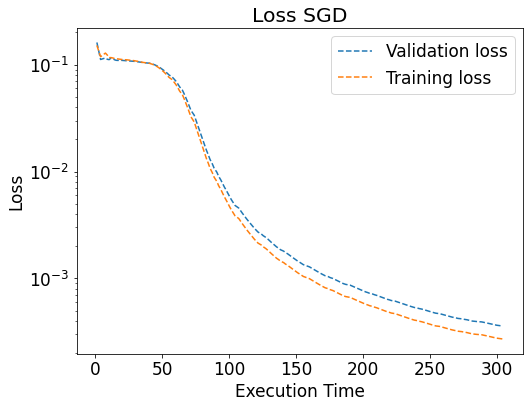

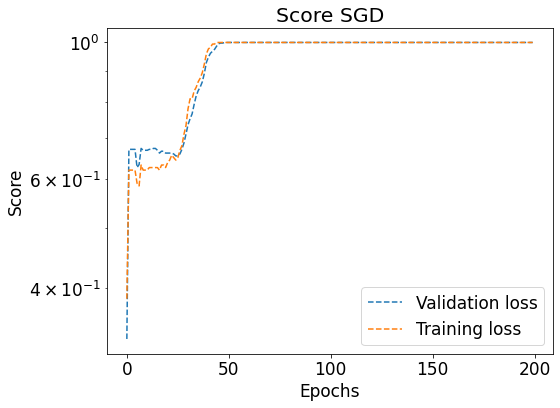

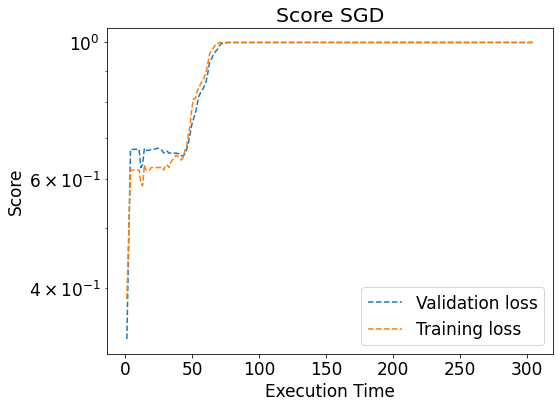

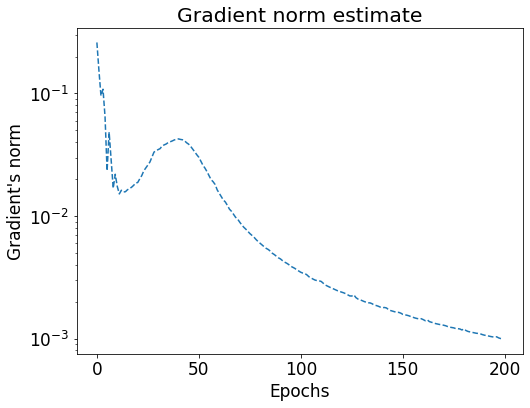

ep: 10000   | s: [16, 32] | b: 169 | e:  0.8 | lmbda:  0.0 | m:  0.5 | nesterov: True
Grad: 9.92151e-04 | Loss: 3.58321e-04, 2.71169e-04 | Score:     1, 1    
ended in: 304.442, avg per ep: 0.0304442
total update: 103.714, avg updt: 0.0103714
total ff: 600, total ff time: 154.026, avg ff: 0.25671
total bp: 200, total bp time: 42.87800000000007, avg bp: 0.21439000000000036
total ev: 200, total ev time: 192.48899999999998, avg ev: 0.9624449999999999


{'batch_size': None, 'epochs': 10000, 'eps': 0.001, 'eta': 0.1, 'lmbda': 0.0, 'optimizer': 'SGM', 'sizes': [16, 32], 'debug': True}


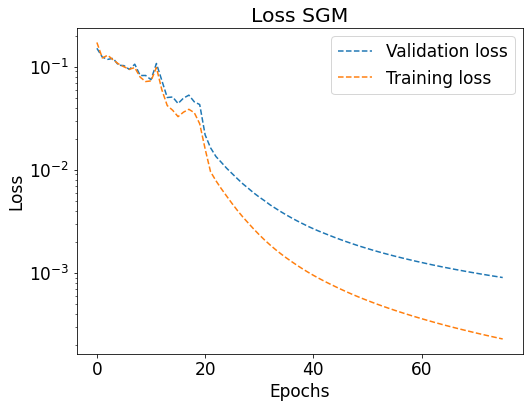

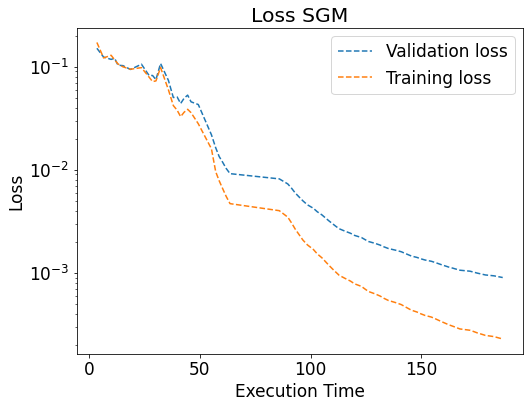

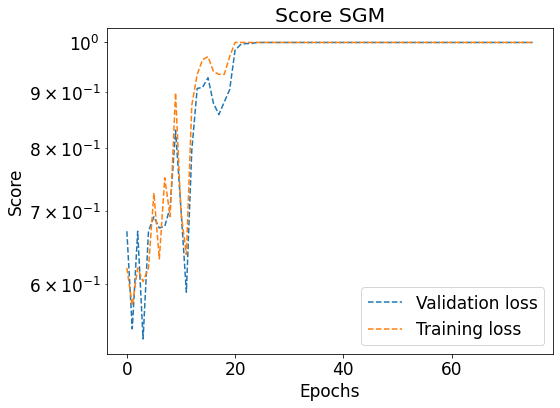

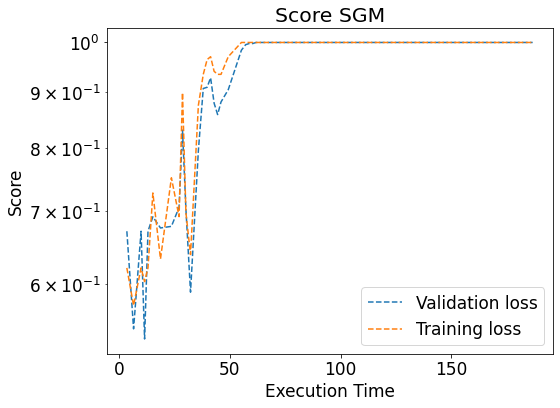

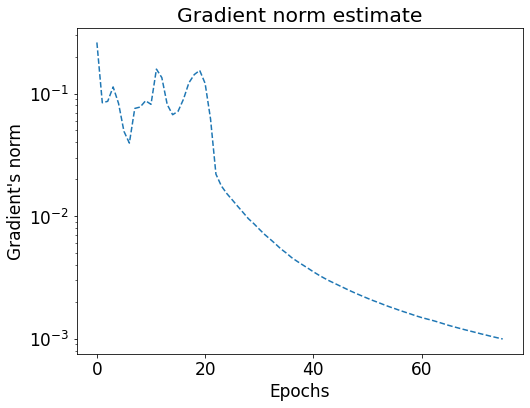

ep: 10000   | s: [16, 32] | b: 169 | e:  0.1 | lmbda:  0.0 | m:  0.5 | nesterov: False
Grad: 9.96110e-04 | Loss: 9.00407e-04, 2.28306e-04 | Score:     1, 1    
ended in: 186.918, avg per ep: 0.0186918
total update: 76.66600000000003, avg updt: 0.007666600000000003
total ff: 228, total ff time: 85.99800000000009, avg ff: 0.3771842105263162
total bp: 76, total bp time: 42.46700000000001, avg bp: 0.5587763157894738
total ev: 76, total ev time: 106.20399999999998, avg ev: 1.3974210526315787




<Figure size 576x432 with 0 Axes>

In [52]:
plot_stats(sgd_cm, dataset=dataset, test='SGD', net=net_cm, log=True)
plot_stats(sgd_nag, dataset=dataset, test='SGD', net=net_nag, log=True)
plot_stats(adam, dataset=dataset, test='Adam', net=net_adam, log=True)

----- SGD -----
{'batch_size': None, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.1, 'lmbda': 0.0, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [16, 32], 'debug': True}
ep: 10000   | s: [16, 32] | b: 169 | e:  0.8 | lmbda:  0.0 | m:  0.5 | nesterov: False
Grad: 9.95147e-04 | Loss: 3.58341e-04, 2.68525e-04 | Score:     1, 1    
ended in: 448.131, avg per ep: 0.044813099999999995
total update: 146.78899999999987, avg updt: 0.014678899999999988
total ff: 894, total ff time: 232.2639999999996, avg ff: 0.25980313199105104
total bp: 298, total bp time: 63.68600000000012, avg bp: 0.21371140939597355
total ev: 298, total ev time: 288.57599999999974, avg ev: 0.9683758389261736

 

----- SGD nesterov-----
{'batch_size': None, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.1, 'lmbda': 0.0, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [16, 32], 'debug': True}
ep: 10000   | s: [16, 32] | b: 169 | e:  0.8 | lmbda:  0.0 | m:  0.5 | nesterov: True
Grad: 9.92151e-04 | Loss: 3.58321e-04, 2.71169e-04 | Score:     1,

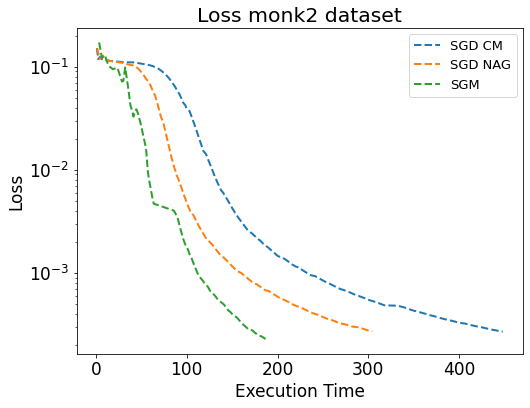

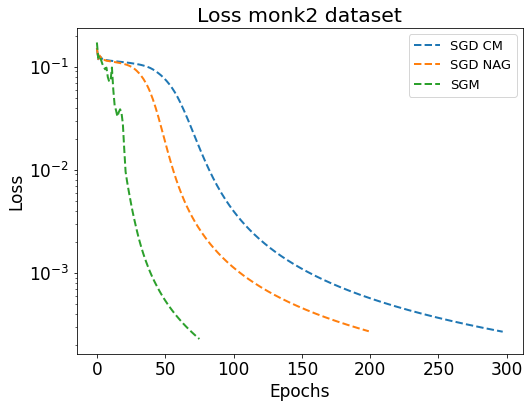

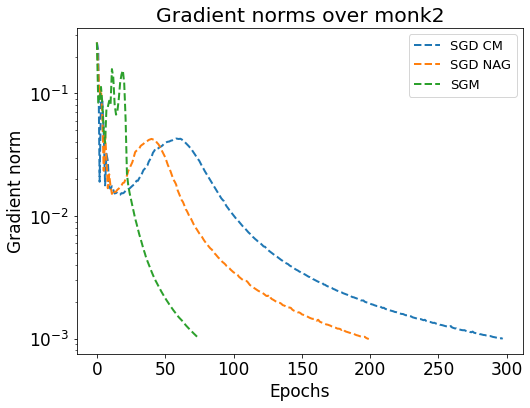

<Figure size 576x432 with 0 Axes>

In [53]:
report_plots(params_conv, dataset, net_SGD=net_cm, net_SGD_nest=net_nag, net_Adam=net_adam, score=score)

### Monk3

In [54]:
debug = False
score = False
dataset = 'monk3'

epochs = 10000
eps = 1e-3

sgd_cm = params[dataset]['SGD'].copy()
sgd_cm['eta'] = 0.8
sgd_cm['epochs'] = epochs
sgd_cm['eps'] = eps

sgd_nag = sgd_cm.copy()
sgd_nag['eta'] = 0.8
sgd_nag['nesterov'] = True
sgd_nag['epochs'] = epochs
sgd_nag['eps'] = eps

adam = params[dataset]['Adam'].copy()
adam['epochs'] = epochs
adam['eps'] = eps
adam['eta'] = 0.2

monk3 = {
    'SGD': sgd_cm,
    'SGD_nest': sgd_nag,
    'Adam': adam
}


net_cm, net_nag, net_adam = convergence_test(dataset, monk3)

1       || Gradient norm: 1.01681e-01 || Loss: 1.44306e-01, 1.38888e-01 || Score: 0.472, 0.508
2       || Gradient norm: 8.66246e-02 || Loss: 1.35088e-01, 1.30617e-01 || Score: 0.472, 0.508
3       || Gradient norm: 6.67228e-02 || Loss: 1.28072e-01, 1.24487e-01 || Score: 0.472, 0.508
4       || Gradient norm: 4.93449e-02 || Loss: 1.23566e-01, 1.20772e-01 || Score: 0.472, 0.508
5       || Gradient norm: 3.76510e-02 || Loss: 1.20695e-01, 1.18524e-01 || Score: 0.521, 0.549
6       || Gradient norm: 3.20712e-02 || Loss: 1.18666e-01, 1.16898e-01 || Score: 0.637, 0.623
7       || Gradient norm: 3.24023e-02 || Loss: 1.16897e-01, 1.15329e-01 || Score: 0.669, 0.664
8       || Gradient norm: 3.41288e-02 || Loss: 1.15124e-01, 1.13630e-01 || Score: 0.692, 0.713
9       || Gradient norm: 3.52326e-02 || Loss: 1.13262e-01, 1.11727e-01 || Score: 0.697, 0.721
10      || Gradient norm: 3.74426e-02 || Loss: 1.11264e-01, 1.09583e-01 || Score: 0.711, 0.738
11      || Gradient norm: 3.88230e-02 || Loss: 1.0

{'batch_size': None, 'epochs': 10000, 'eps': 0.001, 'eta': 0.8, 'lmbda': 0.0001, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [5, 10], 'debug': True}


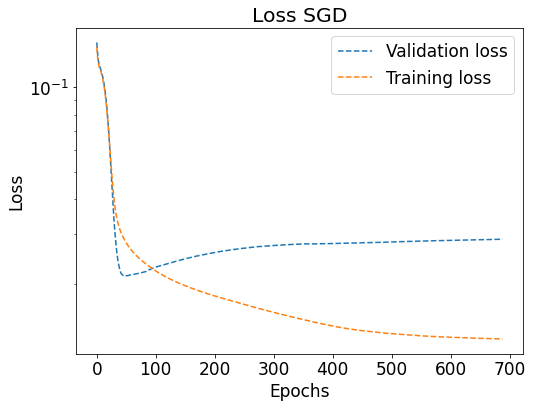

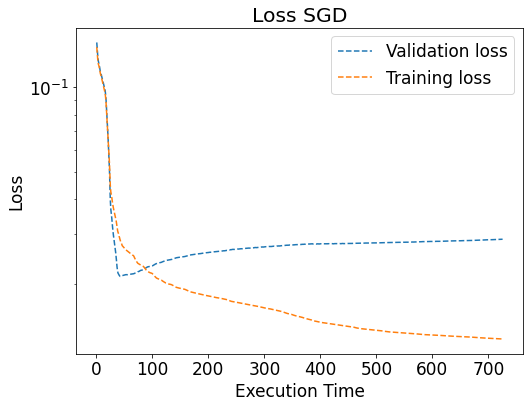

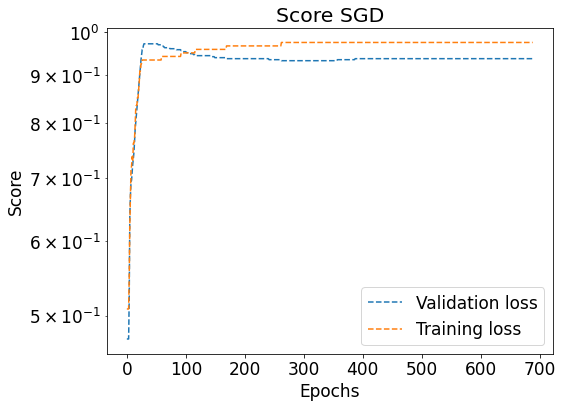

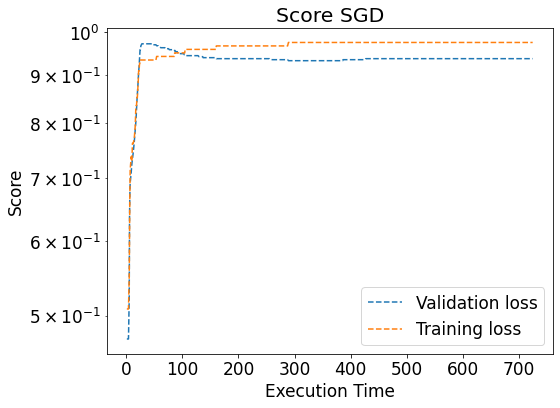

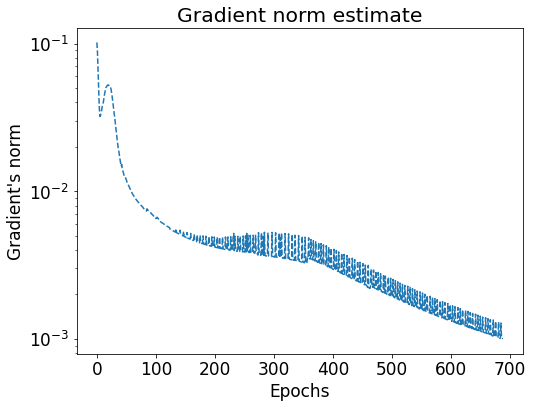

ep: 10000   | s: [5, 10] | b: 122 | e:  0.8 | lmbda:0.0001 | m:  0.5 | nesterov: False
Grad: 9.98609e-04 | Loss: 2.12720e-02, 2.87012e-02 | Score: 0.972, 0.934
ended in: 725.243, avg per ep: 0.0725243
total update: 391.8379999999996, avg updt: 0.03918379999999996
total ff: 2067, total ff time: 340.6369999999996, avg ff: 0.16479777455249134
total bp: 689, total bp time: 99.95500000000018, avg bp: 0.14507256894049372
total ev: 689, total ev time: 298.80599999999964, avg ev: 0.43368069666182824


{'batch_size': None, 'epochs': 10000, 'eps': 0.001, 'eta': 0.8, 'lmbda': 0.0001, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [5, 10], 'debug': True, 'nesterov': True}


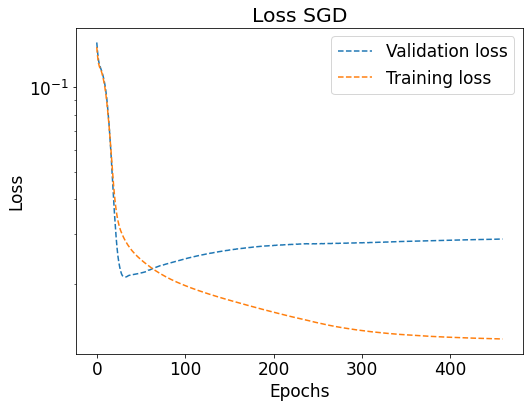

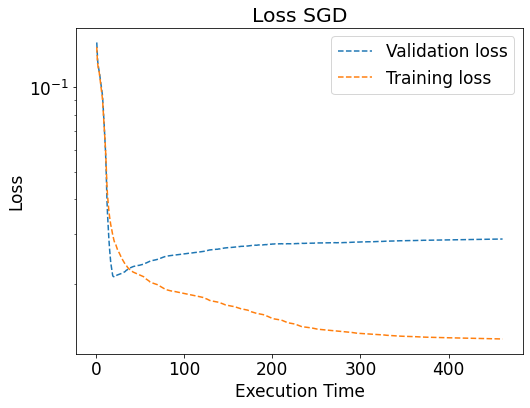

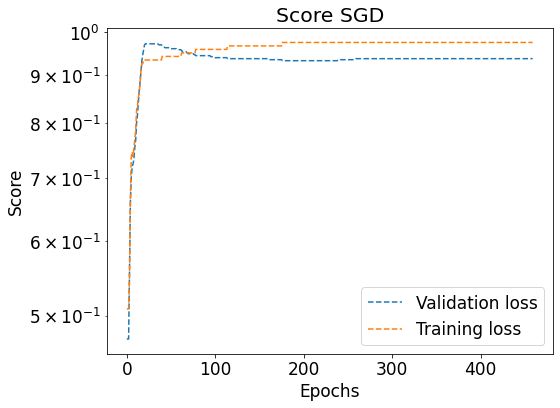

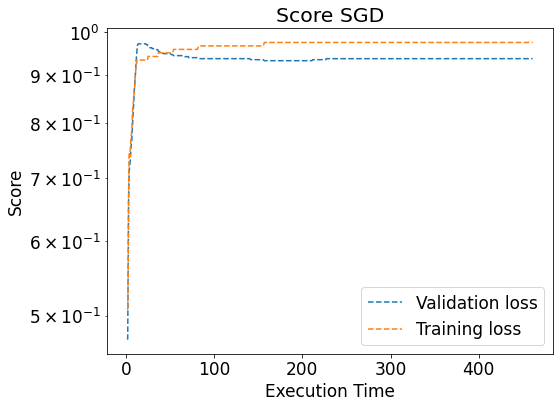

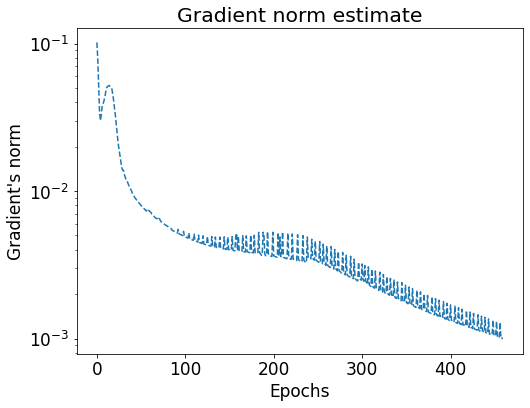

ep: 10000   | s: [5, 10] | b: 122 | e:  0.8 | lmbda:0.0001 | m:  0.5 | nesterov: True
Grad: 9.93390e-04 | Loss: 2.11754e-02, 2.82170e-02 | Score: 0.972, 0.934
ended in: 461.301, avg per ep: 0.0461301
total update: 257.52, avg updt: 0.025751999999999997
total ff: 1380, total ff time: 218.4300000000002, avg ff: 0.15828260869565233
total bp: 460, total bp time: 57.82099999999991, avg bp: 0.12569782608695634
total ev: 460, total ev time: 182.68899999999996, avg ev: 0.39714999999999995


{'batch_size': None, 'epochs': 10000, 'eps': 0.001, 'eta': 0.2, 'lmbda': 0.0001, 'optimizer': 'SGM', 'sizes': [5, 10], 'debug': True}


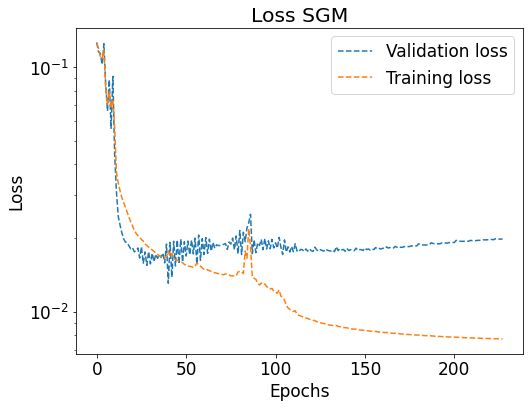

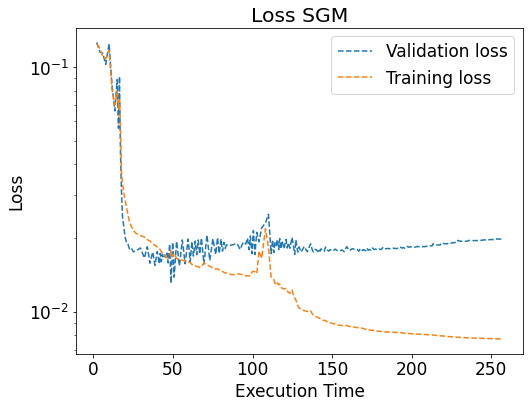

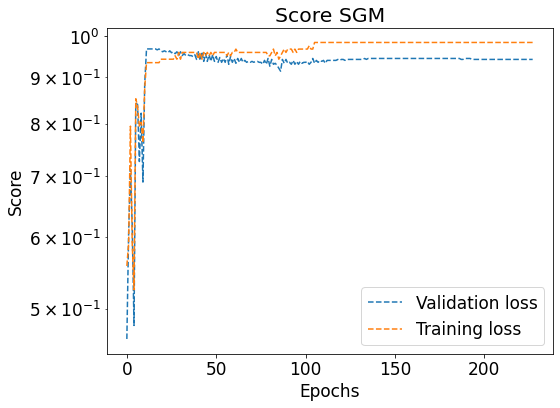

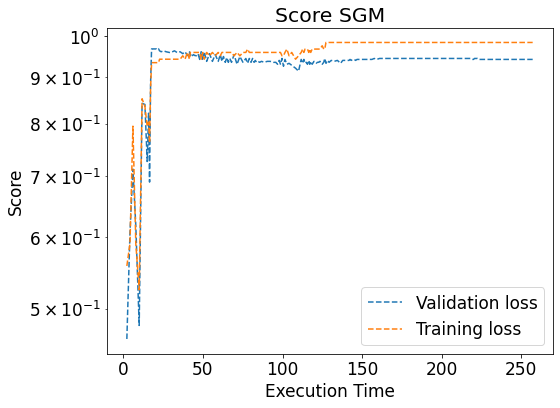

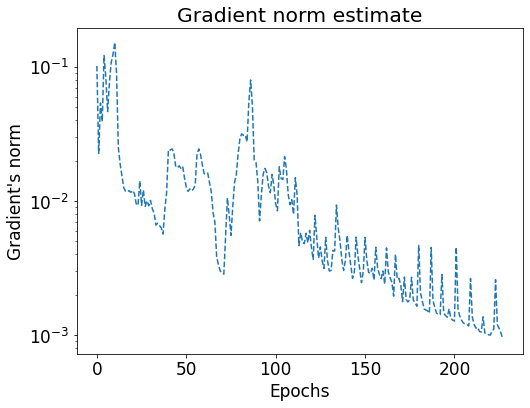

ep: 10000   | s: [5, 10] | b: 122 | e:  0.2 | lmbda:0.0001 | m:  0.5 | nesterov: False
Grad: 9.38087e-04 | Loss: 1.30780e-02, 1.77209e-02 | Score: 0.968, 0.934
ended in: 257.089, avg per ep: 0.0257089
total update: 164.49700000000004, avg updt: 0.016449700000000005
total ff: 684, total ff time: 99.09499999999987, avg ff: 0.14487573099415185
total bp: 228, total bp time: 72.32800000000002, avg bp: 0.3172280701754387
total ev: 228, total ev time: 82.92599999999996, avg ev: 0.3637105263157893




<Figure size 576x432 with 0 Axes>

In [55]:
plot_stats(sgd_cm, dataset=dataset, test='SGD', net=net_cm, log=True)
plot_stats(sgd_nag, dataset=dataset, test='SGD', net=net_nag, log=True)
plot_stats(adam, dataset=dataset, test='Adam', net=net_adam, log=True)

----- SGD -----
{'batch_size': None, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.01, 'lmbda': 0.0001, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [5, 10], 'debug': True}
ep: 10000   | s: [5, 10] | b: 122 | e:  0.8 | lmbda:0.0001 | m:  0.5 | nesterov: False
Grad: 9.98609e-04 | Loss: 2.12720e-02, 2.87012e-02 | Score: 0.972, 0.934
ended in: 725.243, avg per ep: 0.0725243
total update: 391.8379999999996, avg updt: 0.03918379999999996
total ff: 2067, total ff time: 340.6369999999996, avg ff: 0.16479777455249134
total bp: 689, total bp time: 99.95500000000018, avg bp: 0.14507256894049372
total ev: 689, total ev time: 298.80599999999964, avg ev: 0.43368069666182824

 

----- SGD nesterov-----
{'batch_size': None, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.01, 'lmbda': 0.0001, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [5, 10], 'debug': True}
ep: 10000   | s: [5, 10] | b: 122 | e:  0.8 | lmbda:0.0001 | m:  0.5 | nesterov: True
Grad: 9.93390e-04 | Loss: 2.11754e-02, 2.82170e-02 | Score: 0.972, 0.93

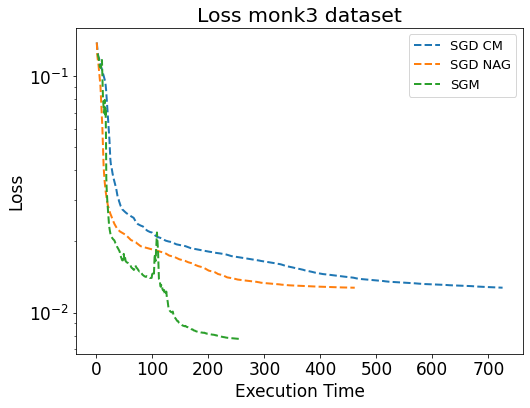

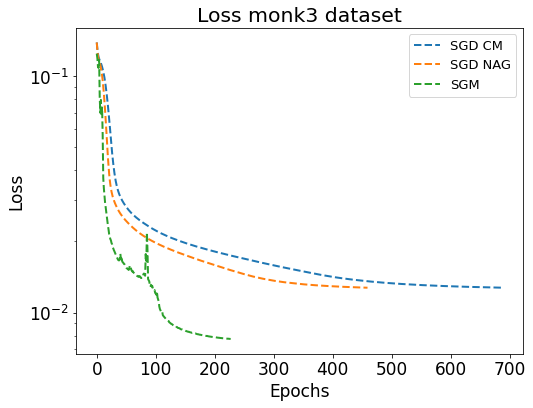

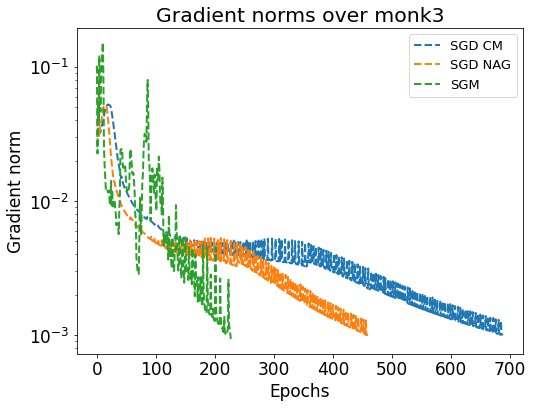

<Figure size 576x432 with 0 Axes>

In [56]:
report_plots(params_conv, dataset, net_SGD=net_cm, net_SGD_nest=net_nag, net_Adam=net_adam, score=score)

### Cup

In [39]:
debug = False
score = False
dataset = 'cup'

epochs = 2000
eps = 5e-2

sgd_cm = params[dataset]['SGD'].copy()
sgd_cm['eta'] = 0.001
sgd_cm['epochs'] = epochs
sgd_cm['eps'] = eps

sgd_nag = sgd_cm.copy()
sgd_nag['eta'] = 0.001
sgd_nag['nesterov'] = True
sgd_nag['epochs'] = epochs
sgd_nag['eps'] = eps

adam = params[dataset]['Adam']
adam['epochs'] = epochs
adam['eps'] = eps
adam['eta'] = 0.2

cup = {
    'SGD': sgd_cm,
    'SGD_nest': sgd_nag,
    'Adam': adam
}

net_cm, net_nag, net_adam = convergence_test(dataset, cup)

1       || Gradient norm: 2.04875e+02 || Loss: 8.09716e+02, 8.24768e+02 || Score: -8.07, -8.63
2       || Gradient norm: 2.12169e+02 || Loss: 7.66830e+02, 7.81122e+02 || Score: -7.59, -8.12
3       || Gradient norm: 2.37444e+02 || Loss: 6.93345e+02, 7.06000e+02 || Score: -6.77, -7.25
4       || Gradient norm: 2.96836e+02 || Loss: 5.63820e+02, 5.72697e+02 || Score: -5.34, -5.71
5       || Gradient norm: 3.99840e+02 || Loss: 3.33655e+02, 3.34430e+02 || Score: -2.81, -2.98
6       || Gradient norm: 4.85520e+02 || Loss: 8.44574e+01, 8.26024e+01 || Score: -0.129, -0.162
7       || Gradient norm: 1.74654e+02 || Loss: 3.96097e+02, 4.47560e+02 || Score: -3.64, -4.44
8       || Gradient norm: 1.78395e+03 || Loss: 9.26176e+01, 9.17392e+01 || Score: -0.0823, -0.125
9       || Gradient norm: 4.51393e+02 || Loss: 1.94920e+02, 1.85781e+02 || Score: -1.07, -1.06
10      || Gradient norm: 5.76012e+02 || Loss: 2.40226e+02, 2.43293e+02 || Score: -1.55, -1.7 
11      || Gradient norm: 4.28859e+02 || Loss

{'batch_size': None, 'epochs': 2000, 'eps': 0.05, 'eta': 0.001, 'lmbda': 0.01, 'momentum': 0.9, 'optimizer': 'SGD', 'sizes': [16, 32], 'debug': True}


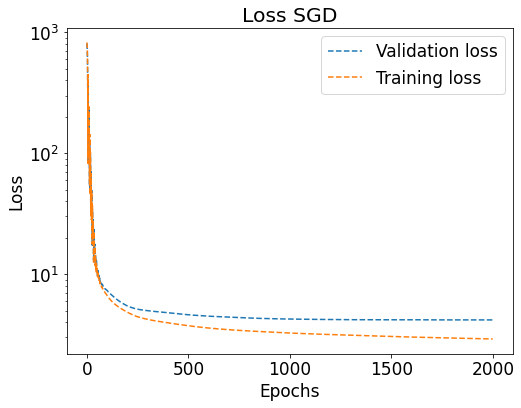

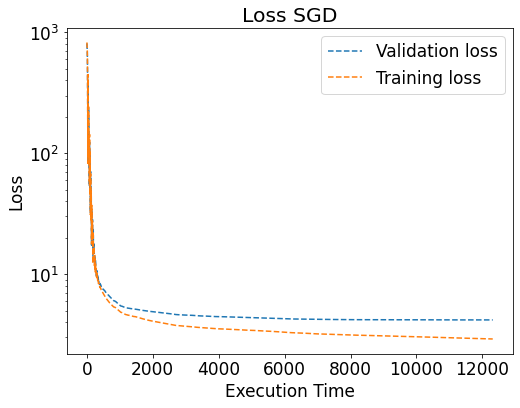

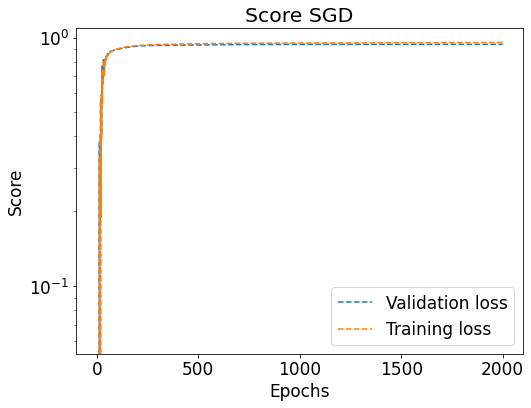

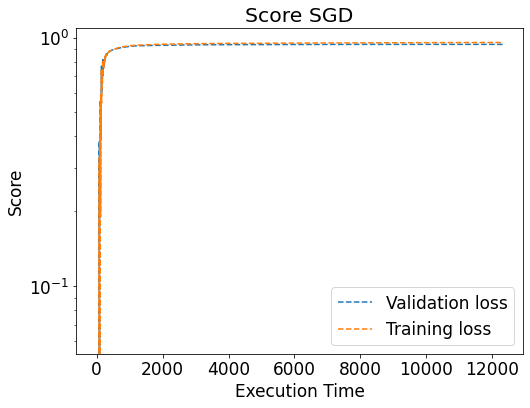

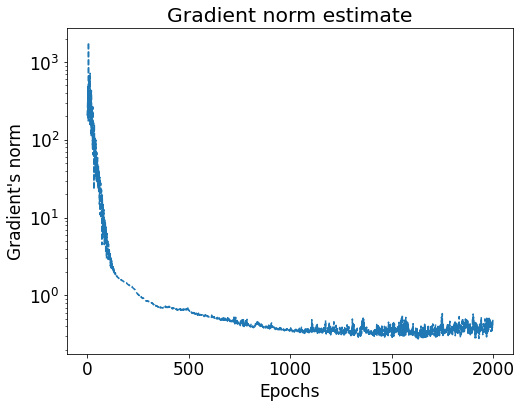

ep: 2000    | s: [16, 32] | b: 1066 | e:0.001 | lmbda: 0.01 | m:  0.9 | nesterov: False
Grad: 4.90515e-01 | Loss: 4.18102e+00, 2.91001e+00 | Score: 0.939, 0.953
ended in: 12314.842, avg per ep: 6.157421
total update: 5989.172, avg updt: 2.994586
total ff: 6000, total ff time: 6145.183999999991, avg ff: 1.0241973333333318
total bp: 2000, total bp time: 2890.5920000000015, avg bp: 1.4452960000000008
total ev: 2000, total ev time: 6189.65299999999, avg ev: 3.094826499999995


{'batch_size': None, 'epochs': 2000, 'eps': 0.05, 'eta': 0.001, 'lmbda': 0.01, 'momentum': 0.9, 'optimizer': 'SGD', 'sizes': [16, 32], 'debug': True, 'nesterov': True}


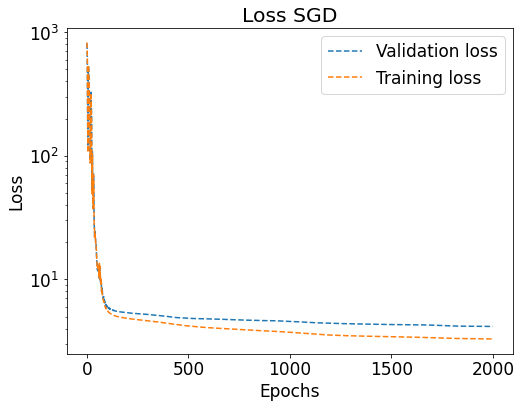

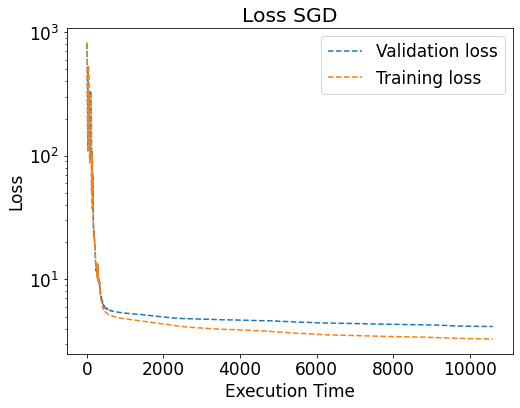

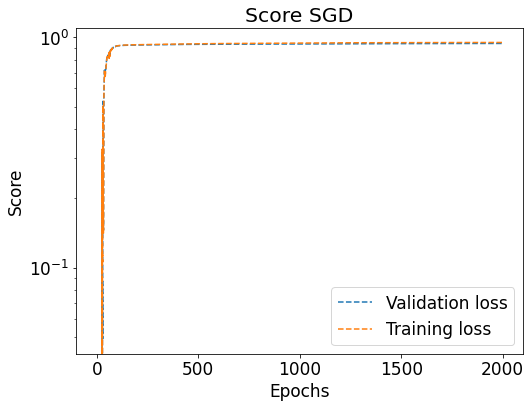

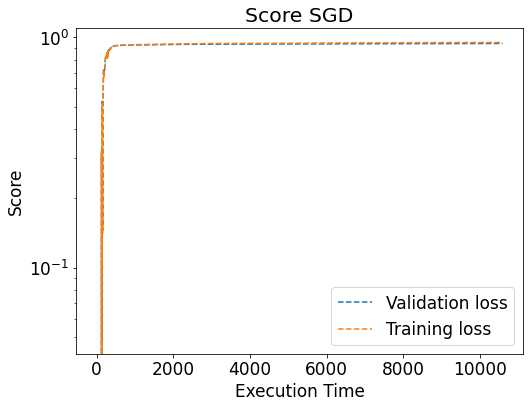

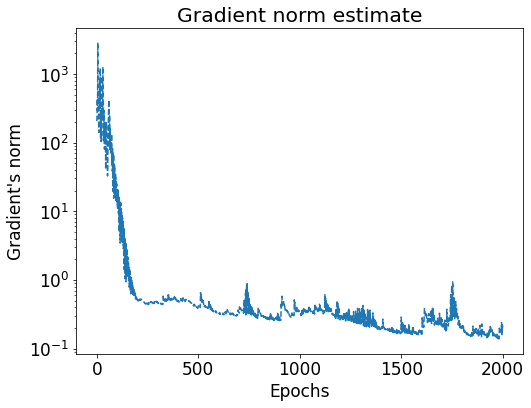

ep: 2000    | s: [16, 32] | b: 1066 | e:0.001 | lmbda: 0.01 | m:  0.9 | nesterov: True
Grad: 2.01574e-01 | Loss: 4.15687e+00, 3.29220e+00 | Score: 0.939, 0.949
ended in: 10588.409, avg per ep: 5.2942045
total update: 5021.937000000003, avg updt: 2.5109685000000015
total ff: 6000, total ff time: 4781.102999999977, avg ff: 0.7968504999999962
total bp: 2000, total bp time: 2483.2130000000043, avg bp: 1.241606500000002
total ev: 2000, total ev time: 5435.101000000002, avg ev: 2.717550500000001


{'batch_size': None, 'epochs': 2000, 'eps': 0.05, 'eta': 0.2, 'lmbda': 0.01, 'optimizer': 'SGM', 'sizes': [16, 32], 'debug': True}


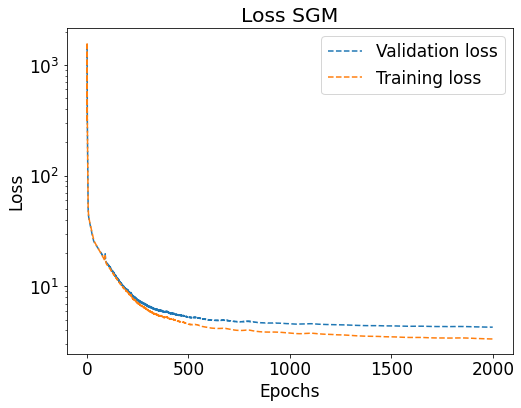

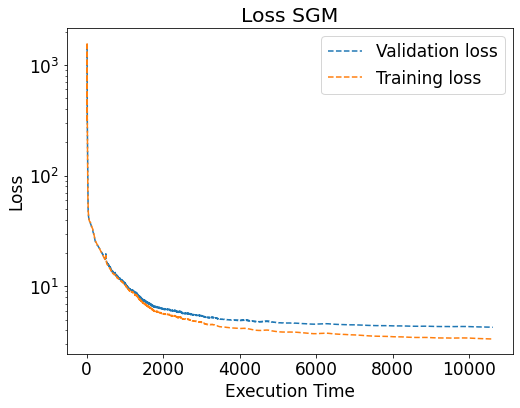

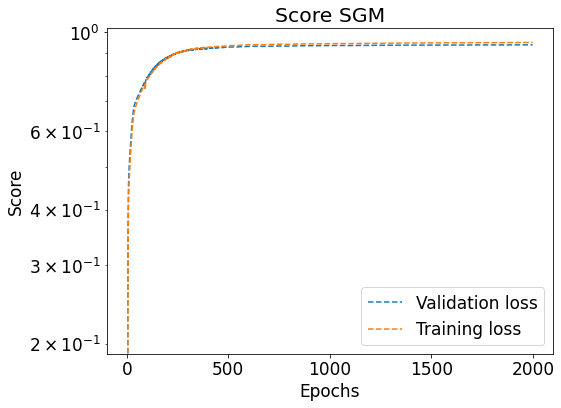

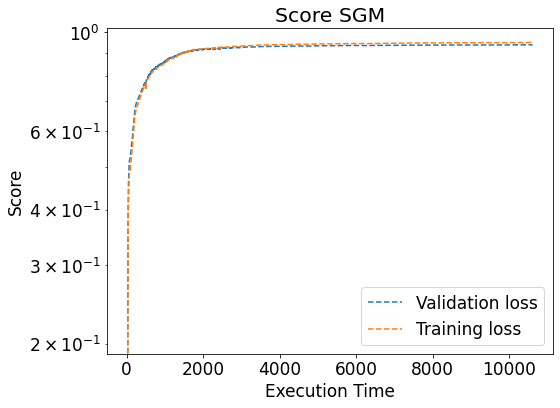

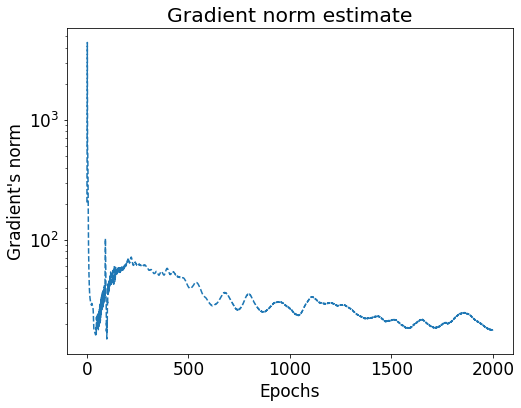

ep: 2000    | s: [16, 32] | b: 1066 | e:  0.2 | lmbda: 0.01 | m:  0.0 | nesterov: False
Grad: 1.78147e+01 | Loss: 4.27726e+00, 3.34866e+00 | Score: 0.938, 0.95 
ended in: 10610.071, avg per ep: 5.3050355
total update: 5376.537000000006, avg updt: 2.688268500000003
total ff: 6000, total ff time: 4062.278999999976, avg ff: 0.677046499999996
total bp: 2000, total bp time: 3221.5860000000066, avg bp: 1.6107930000000032
total ev: 2000, total ev time: 5098.006000000007, avg ev: 2.5490030000000035




<Figure size 576x432 with 0 Axes>

In [40]:
plot_stats(sgd_cm, dataset=dataset, test='SGD', net=net_cm, log=True)
plot_stats(sgd_nag, dataset=dataset, test='SGD', net=net_nag, log=True)
plot_stats(adam, dataset=dataset, test='Adam', net=net_adam, log=True)

----- SGD -----
{'batch_size': None, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.001, 'lmbda': 0.01, 'momentum': 0.9, 'optimizer': 'SGD', 'sizes': [16, 32], 'debug': True}
ep: 2000    | s: [16, 32] | b: 1066 | e:0.001 | lmbda: 0.01 | m:  0.9 | nesterov: False
Grad: 4.90515e-01 | Loss: 4.18102e+00, 2.91001e+00 | Score: 0.939, 0.953
ended in: 12948.823, avg per ep: 6.4744115
total update: 1.692, avg updt: 0.000846
total ff: 6000, total ff time: 6686.485999999992, avg ff: 1.1144143333333318
total bp: 2000, total bp time: 3092.369000000008, avg bp: 1.5461845000000038
total ev: 2000, total ev time: 6270.783999999998, avg ev: 3.135391999999999

 

----- SGD nesterov-----
{'batch_size': None, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.001, 'lmbda': 0.01, 'momentum': 0.9, 'optimizer': 'SGD', 'sizes': [16, 32], 'debug': True}
ep: 2000    | s: [16, 32] | b: 1066 | e:0.001 | lmbda: 0.01 | m:  0.9 | nesterov: True
Grad: 2.01574e-01 | Loss: 4.15687e+00, 3.29220e+00 | Score: 0.939, 0.949
ended in: 11119.451,

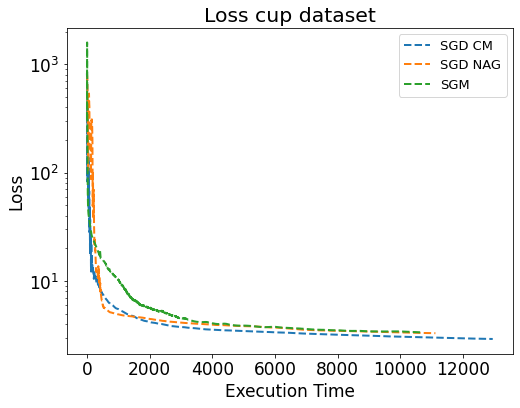

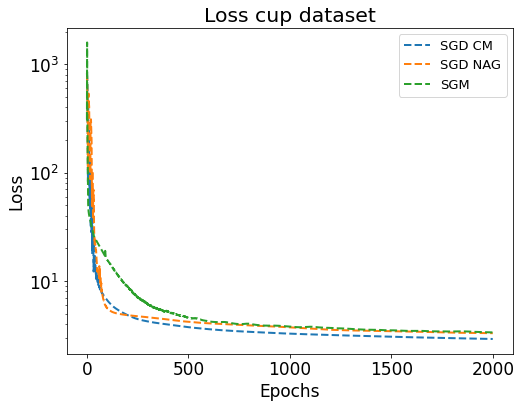

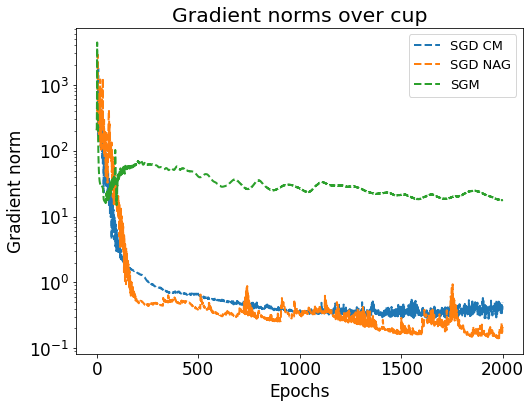

<Figure size 576x432 with 0 Axes>

In [48]:
report_plots(params_conv, dataset, net_SGD=net_cm, net_SGD_nest=net_nag, net_Adam=net_adam, score=score)